# Merge the prophage counts based on the host's taxonomy

We are going to use the [GTDB](https://gtdb.ecogenomic.org/) taxonomy to count the number of prophages at different levels. Because of this, we merge with the GTDB metadata file.

In [61]:
# A lot of this is not used, but we import it so we have it later!
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter

import pandas as pd
import seaborn as sns
import numpy as np

import math
import re
import string
from PhiSpyAnalysis import theils_u, DateConverter, file_to_accession

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA


import subprocess
import gzip


# this is a neat trick for getting markdown in our output
# see https://stackoverflow.com/questions/23271575/printing-bold-colored-etc-text-in-ipython-qtconsole
# for the inspiration
from IPython.display import Markdown, display
def printmd(string, color="black", end="\n"):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [2]:
use_small_data = False
if use_small_data:
    phagesdf = pd.read_csv("../small_data/phages_per_genome.tsv.gz", compression='gzip', header=0, delimiter="\t")
else:
    phagesdf = pd.read_csv("../data/phages_per_genome.tsv.gz", compression='gzip', header=0, delimiter="\t")
phagesdf['assembly_accession'] = phagesdf['Contig'].apply(file_to_accession)
githash = subprocess.check_output(["git", "describe", "--always"]).strip().decode()
print(f"Please note that this was run with git commit {githash} that has {phagesdf.shape[0]:,} genomes parsed and {phagesdf['Total Predicted Prophages'].sum():,} total prophages")

Please note that this was run with git commit e9da370 that has 553,082 genomes parsed and 20,946,107 total prophages


### Read the data file

The metadata is from GTDB. The phage data is from us.


In [3]:
gtdb = pd.read_csv("../data/bac120_metadata_r95.tsv.gz", compression='gzip', header=0, delimiter="\t")
gtdb = gtdb.rename(columns={'ncbi_genbank_assembly_accession': 'assembly_accession'})
gtdb

c:\workspace\edwa0468\githubs\phispyanalysis\venv\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (61,65,74,82,83) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,accession,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,...,ssu_silva_blast_align_len,ssu_silva_blast_bitscore,ssu_silva_blast_evalue,ssu_silva_blast_perc_identity,ssu_silva_blast_subject_id,ssu_silva_taxonomy,total_gap_length,trna_aa_count,trna_count,trna_selenocysteine_count
0,GB_GCA_000006155.2,1916,93.12,0.00,1171,g__Bacillus (UID902),324,0.0,4305660,80.178992,...,none,none,none,none,none,none,42300,16,31,0
1,GB_GCA_000007385.1,0,99.82,0.00,481,c__Gammaproteobacteria (UID4202),276,0.0,4190634,84.805944,...,1541,2846,0,100,JXEG01000201.4293.5839,Bacteria;Proteobacteria;Gammaproteobacteria;Xa...,0,20,53,0
2,GB_GCA_000008605.1,67,100.00,0.00,235,f__Spirochaetaceae (UID2512),124,0.0,1048744,92.155875,...,1545,2854,0,100,CP003679.231299.232859,Bacteria;Spirochaetes;Spirochaetia;Spirochaeta...,0,20,45,0
3,GB_GCA_000010565.1,0,100.00,0.63,295,p__Firmicutes (UID1022),158,0.0,2608397,86.217312,...,1526,2819,0,100,AP009389.1049070.1050595,Bacteria;Firmicutes;Clostridia;Clostridiales;P...,0,20,51,1
4,GB_GCA_000013845.2,0,100.00,0.00,332,o__Clostridiales (UID1375),124,0.0,2428396,82.037966,...,1509,2787,0,100,CP000312.233320.234832,Bacteria;Firmicutes;Clostridia;Clostridiales;C...,0,20,95,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191522,RS_GCF_902166935.1,0,99.62,0.09,1312,g__Klebsiella (UID5140),336,0.0,4894244,87.293148,...,1536,2837,0,100,MAPL01000082.143.1696,Bacteria;Proteobacteria;Gammaproteobacteria;En...,0,20,87,1
191523,RS_GCF_902166945.1,0,99.94,0.72,1162,f__Enterobacteriaceae (UID5121),336,0.0,5162721,86.540042,...,1536,2837,0,100,CP016813.16076.17629,Bacteria;Proteobacteria;Gammaproteobacteria;En...,0,20,86,1
191524,RS_GCF_902167295.1,0,99.51,0.00,303,p__Bacteroidetes (UID2591),203,0.0,5737447,90.122088,...,1490,2747,0,99.933,JX101438.1.1490,Bacteria;Bacteroidetes;Bacteroidia;Chitinophag...,0,20,58,0
191525,RS_GCF_902167305.1,0,99.51,0.00,303,p__Bacteroidetes (UID2591),203,0.0,5738096,90.147873,...,1490,2747,0,99.933,JX101438.1.1490,Bacteria;Bacteroidetes;Bacteroidia;Chitinophag...,0,20,58,0


### Abstract out the accession and name into new columns

This will allow us to merge the data with the PATRIC and GTDB data

In [4]:
acccol = 'assembly_accession'

## Sanity check

This is just to make sure that we are all working on the same data. Here, we make a temporary data frame that has the number of contigs and the number of basepairs in the genome, and use those to compare to see if we think we are working on the same thing.

If we find columns that are no good, we should delete them (but we don't, yay!)

In [5]:
def are_same(x):
    # currently fixing contig counts, so when that is done delete the next line and uncomment the one after
    return x['genome_size'] == x['Genome length']
    # return x['genome_size'] == x['Genome length'] and x['contig_count'] == x['Contigs']

comparison = pd.merge(gtdb[[acccol, 'contig_count', 'genome_size']],
                      phagesdf[[acccol, 'Contigs', 'Genome length']],
                      how='inner', left_on=acccol, right_on=acccol)

comparison['same'] = comparison.apply(are_same, axis=1)
# look for rows that are not the same
comparison[comparison['same']==False]

,assembly_accession,contig_count,genome_size,Contigs,Genome length,same


## Filter the genomes

We should probably filter out based on quality. We have three quality scores (mimag high/medium/low) plus the number of contigs. Lets make a little violin plot of the quality vs Total or Kept prophages.


In [6]:
qual = pd.merge(gtdb[[acccol, 'checkm_completeness', 'gc_percentage', 'contig_count', 'genome_size', 'mimag_high_quality', 'mimag_low_quality', 'mimag_medium_quality']],
                phagesdf[[acccol, 'Total Predicted Prophages', 'Kept']],
                how='inner', left_on=acccol, right_on=acccol)
qual

,assembly_accession,checkm_completeness,gc_percentage,contig_count,genome_size,mimag_high_quality,mimag_low_quality,mimag_medium_quality,Total Predicted Prophages,Kept
0,GCA_000006155.2,93.12,35.101404,426,5370060,f,f,t,5,0
1,GCA_000007385.1,99.82,63.693289,1,4941439,t,f,f,29,4
2,GCA_000008605.1,100.00,52.775181,1,1138011,t,f,f,5,1
3,GCA_000010565.1,100.00,52.961104,1,3025375,t,f,f,25,2
4,GCA_000013845.2,100.00,28.230917,4,2960088,t,f,f,12,2
...,...,...,...,...,...,...,...,...,...,...
126124,GCA_902158665.1,100.00,55.252894,23,6052172,t,f,f,29,0
126125,GCA_902158685.1,100.00,55.244893,38,6020052,t,f,f,27,2
126126,GCA_902158695.1,100.00,55.248393,59,6071600,t,f,f,27,5
126127,GCA_902158715.1,100.00,54.639170,65,6393461,t,f,f,31,1


In [7]:
def mimag_qual(x):
    if x['mimag_high_quality'] == 't':
        return "High"
    if x['mimag_medium_quality'] == 't':
        return "Medium"
    if x['mimag_low_quality'] == 't':
        return "Low"
    return "Unknown"

qual['Mimag quality'] = qual.apply(mimag_qual, axis=1)
qual

,assembly_accession,checkm_completeness,gc_percentage,contig_count,genome_size,mimag_high_quality,mimag_low_quality,mimag_medium_quality,Total Predicted Prophages,Kept,Mimag quality
0,GCA_000006155.2,93.12,35.101404,426,5370060,f,f,t,5,0,Medium
1,GCA_000007385.1,99.82,63.693289,1,4941439,t,f,f,29,4,High
2,GCA_000008605.1,100.00,52.775181,1,1138011,t,f,f,5,1,High
3,GCA_000010565.1,100.00,52.961104,1,3025375,t,f,f,25,2,High
4,GCA_000013845.2,100.00,28.230917,4,2960088,t,f,f,12,2,High
...,...,...,...,...,...,...,...,...,...,...,...
126124,GCA_902158665.1,100.00,55.252894,23,6052172,t,f,f,29,0,High
126125,GCA_902158685.1,100.00,55.244893,38,6020052,t,f,f,27,2,High
126126,GCA_902158695.1,100.00,55.248393,59,6071600,t,f,f,27,5,High
126127,GCA_902158715.1,100.00,54.639170,65,6393461,t,f,f,31,1,High


In [8]:
qual[qual['Mimag quality'] == 'Unknown']

,assembly_accession,checkm_completeness,gc_percentage,contig_count,genome_size,mimag_high_quality,mimag_low_quality,mimag_medium_quality,Total Predicted Prophages,Kept,Mimag quality
647,GCA_000448165.1,96.05,51.522661,127,2260155,f,f,f,37,3,Unknown
673,GCA_000480235.1,98.94,57.249530,30,3504296,f,f,f,10,1,Unknown
762,GCA_000555645.1,98.28,32.957739,58,3165229,f,f,f,11,6,Unknown
799,GCA_000682315.1,99.32,39.005359,589,4635745,f,f,f,99,5,Unknown
985,GCA_000954095.1,96.17,35.753954,656,3145901,f,f,f,26,0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...
104891,GCA_006373885.1,100.00,45.501506,285,5115756,f,f,f,44,2,Unknown
105226,GCA_006385165.1,98.62,39.950964,8,2189419,f,f,f,25,1,Unknown
112709,GCA_900103395.1,99.68,59.189659,26,6477618,f,f,f,36,5,Unknown
112737,GCA_900103765.1,99.68,59.153631,26,6562057,f,f,f,36,7,Unknown


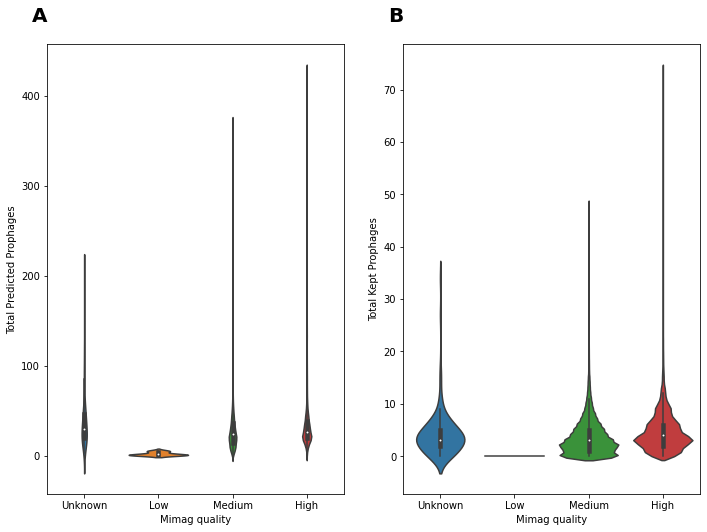

In [9]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.violinplot(x='Mimag quality', y='Total Predicted Prophages', jitter=True, data=qual, ax=ax[0], order=['Unknown', 'Low', 'Medium', 'High'])
#sns.stripplot(x='Mimag quality', y='Total Predicted Prophages',  jitter=True, data=qual, alpha=0.1, ax=ax[0], color='k')

sns.violinplot(x='Mimag quality', y='Kept', jitter=True, data=qual, ax=ax[1], order=['Unknown', 'Low', 'Medium', 'High'])
#sns.stripplot(x='Mimag quality', y='Kept',  jitter=True, data=qual, color='k', alpha=0.1, ax=ax[1])
ax[1].set_ylabel("Total Kept Prophages")

for n, a in enumerate(ax):
    a.text(-0.05, 1.05, string.ascii_uppercase[n], transform=a.transAxes, size=20, weight='bold')

plt.show()


### How does completeness/size compare with predictions?

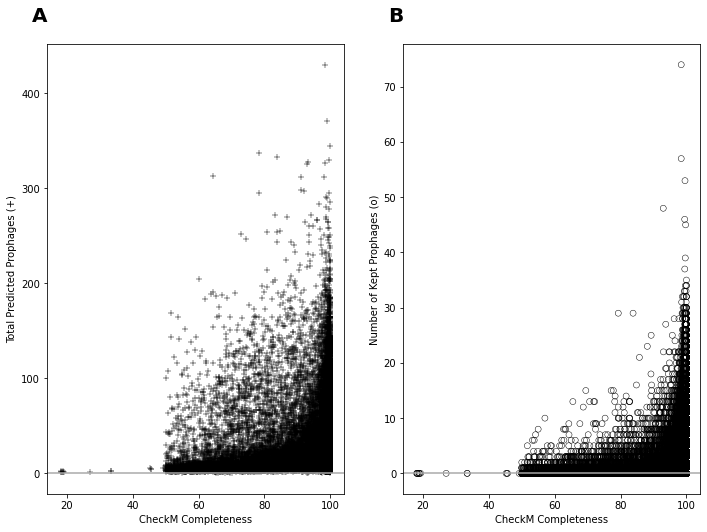

In [10]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.scatterplot(x='checkm_completeness', y='Total Predicted Prophages', data=qual, marker='+', color='k', ax=ax[0])
sns.scatterplot(x='checkm_completeness', y='Kept', data=qual, marker='o', facecolors='none', edgecolor='k', ax=ax[1])
# ax2.grid(False)
ax[1].set_ylabel('Number of Kept Prophages (o)')
ax[0].set_ylabel('Total Predicted Prophages (+)')
ax[0].set_xlabel('CheckM Completeness')
ax[1].set_xlabel('CheckM Completeness')
ax[0].axhline(y=0, color='darkgrey')
ax[1].axhline(y=0, color='darkgrey')

for n, a in enumerate(ax):
    a.text(-0.05, 1.05, string.ascii_uppercase[n], transform=a.transAxes, size=20, weight='bold')

fig.savefig("images/checkm_vs_phages.svg")

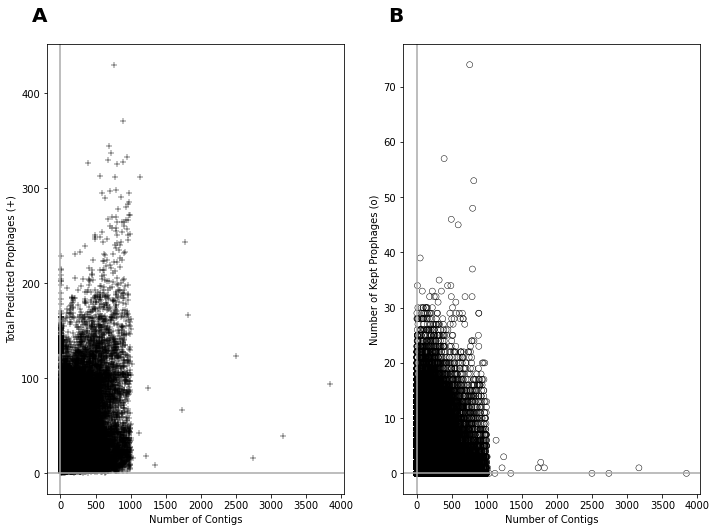

In [11]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.scatterplot(x='contig_count', y='Total Predicted Prophages', data=qual, marker='+', ax=ax[0], color='k')
sns.scatterplot(x='contig_count', y='Kept', data=qual, marker='o', facecolors='none', edgecolor='k', ax=ax[1])

ax[1].set_ylabel('Number of Kept Prophages (o)')
ax[0].set_ylabel('Total Predicted Prophages (+)')
ax[0].set_xlabel('Number of Contigs')
ax[1].set_xlabel('Number of Contigs')
ax[0].axhline(y=0, color='darkgrey')
ax[0].axvline(x=0, color='darkgrey')
ax[1].axhline(y=0, color='darkgrey')
ax[1].axvline(x=0, color='darkgrey')

for n, a in enumerate(ax):
    a.text(-0.05, 1.05, string.ascii_uppercase[n], transform=a.transAxes, size=20, weight='bold')

fig.savefig("images/contigs_vs_phages.svg")


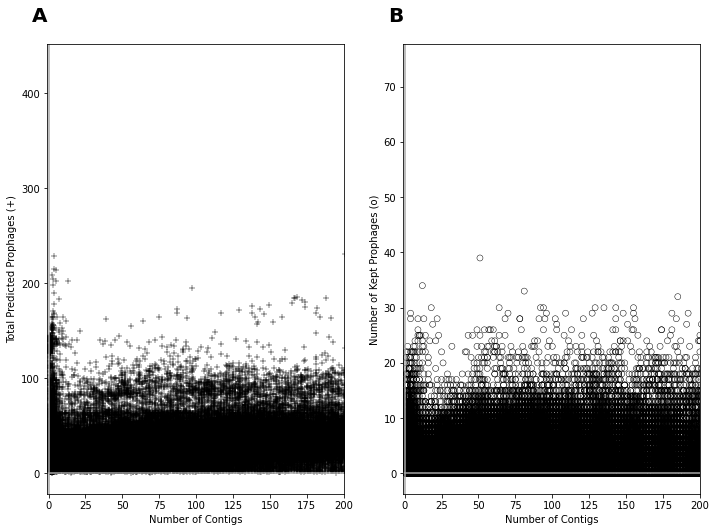

In [12]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.scatterplot(x='contig_count', y='Total Predicted Prophages', data=qual, marker='+', ax=ax[0], color='k')
sns.scatterplot(x='contig_count', y='Kept', data=qual, marker='o', facecolors='none', edgecolor='k', ax=ax[1])
ax[0].set_xlim(-1,200)
ax[1].set_xlim(-1,200)
ax[1].set_ylabel('Number of Kept Prophages (o)')
ax[0].set_ylabel('Total Predicted Prophages (+)')
ax[0].set_xlabel('Number of Contigs')
ax[1].set_xlabel('Number of Contigs')
ax[0].axhline(y=0, color='darkgrey')
ax[0].axvline(x=0, color='darkgrey')
ax[1].axhline(y=0, color='darkgrey')
ax[1].axvline(x=0, color='darkgrey')


for n, a in enumerate(ax):
    a.text(-0.05, 1.05, string.ascii_uppercase[n], transform=a.transAxes, size=20, weight='bold')

fig.savefig("images/contigs_vs_phages_0200.svg")

At the moment there doesn't seem to be an obvious reason to cut or cull any of these predictions!

# Compare CheckM and CheckV

See if high/medium/low phage genomes correlate with other predictions?

In [13]:
if use_small_data:
    checkv = pd.read_csv("../small_data/checkv.tsv.gz", compression='gzip', header=0, delimiter="\t")
else:
    checkv = pd.read_csv("../data/checkv.tsv.gz", compression='gzip', header=0, delimiter="\t")
checkv = checkv.rename(columns={"BASE": "Contig"})
checkv['assembly_accession'] = checkv['Contig'].apply(file_to_accession)
checkv

,Contig,contig_id,contig_length,gene_count,viral_genes,host_genes,checkv_quality,miuvig_quality,completeness,assembly_accession
0,GCA_000003135.1_ASM313v1_genomic.gbff.gz,GG666849.1_PP1,20352,30,0,2,Not-determined,Genome-fragment,NaN,GCA_000003135.1
1,GCA_000003135.1_ASM313v1_genomic.gbff.gz,GG666854.1_PP2,28564,28,1,14,Low-quality,Genome-fragment,35.35,GCA_000003135.1
2,GCA_000003645.1_ASM364v1_genomic.gbff.gz,CM000714.1_PP1,40297,55,14,9,Medium-quality,Genome-fragment,53.01,GCA_000003645.1
3,GCA_000003925.1_ASM392v1_genomic.gbff.gz,CM000742.1_PP1,21020,21,0,21,Not-determined,Genome-fragment,NaN,GCA_000003925.1
4,GCA_000003925.1_ASM392v1_genomic.gbff.gz,CM000742.1_PP2,17449,20,1,12,Low-quality,Genome-fragment,9.46,GCA_000003925.1
...,...,...,...,...,...,...,...,...,...,...
1094260,GCA_011445755.1_PDT000053321.2_genomic.gbff.gz,AAQAOR010000025.1_PP3,2331,4,0,0,Not-determined,Genome-fragment,NaN,GCA_011445755.1
1094261,GCA_011445755.1_PDT000053321.2_genomic.gbff.gz,AAQAOR010000028.1_PP4,23624,27,15,2,Medium-quality,Genome-fragment,50.94,GCA_011445755.1
1094262,GCA_011445755.1_PDT000053321.2_genomic.gbff.gz,AAQAOR010000029.1_PP5,6567,6,6,0,Low-quality,Genome-fragment,18.65,GCA_011445755.1
1094263,GCA_011445755.1_PDT000053321.2_genomic.gbff.gz,AAQAOR010000032.1_PP6,18522,13,0,7,Not-determined,Genome-fragment,NaN,GCA_011445755.1


In [14]:
counts = {}
for index, rows in checkv.iterrows():
    if rows['assembly_accession'] not in counts:
        counts[rows['assembly_accession']] = {}
    counts[rows['assembly_accession']][rows['checkv_quality']] = counts[rows['assembly_accession']].get(rows['checkv_quality'], 0) + 1
checkvcounts = pd.DataFrame.from_dict(counts).T
checkvcounts = checkvcounts.reset_index().rename(columns={"index" : "assembly_accession"})
checkvcounts

,assembly_accession,Not-determined,Low-quality,Medium-quality,High-quality,Complete
0,GCA_000003135.1,1.0,1.0,NaN,NaN,NaN
1,GCA_000003645.1,NaN,NaN,1.0,NaN,NaN
2,GCA_000003925.1,2.0,2.0,1.0,1.0,NaN
3,GCA_000003955.1,NaN,2.0,3.0,1.0,NaN
4,GCA_000005825.2,2.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...
206133,GCA_011445675.1,NaN,5.0,3.0,NaN,NaN
206134,GCA_011445695.1,2.0,2.0,1.0,1.0,NaN
206135,GCA_011445715.1,2.0,6.0,1.0,1.0,NaN
206136,GCA_011445735.1,5.0,1.0,NaN,NaN,NaN


In [15]:
checkmv = pd.merge(gtdb[['assembly_accession', 'checkm_completeness']], checkvcounts, left_on='assembly_accession', right_on='assembly_accession', how='inner')
checkmv

,assembly_accession,checkm_completeness,Not-determined,Low-quality,Medium-quality,High-quality,Complete
0,GCA_000007385.1,99.82,2.0,1.0,1.0,NaN,NaN
1,GCA_000008605.1,100.00,NaN,1.0,NaN,NaN,NaN
2,GCA_000010565.1,100.00,1.0,NaN,NaN,1.0,NaN
3,GCA_000013845.2,100.00,1.0,NaN,1.0,NaN,NaN
4,GCA_000014305.1,97.38,3.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
63601,GCA_901472525.1,99.07,NaN,2.0,NaN,NaN,NaN
63602,GCA_901472535.1,91.47,5.0,2.0,2.0,NaN,NaN
63603,GCA_901472545.1,98.81,NaN,3.0,1.0,3.0,NaN
63604,GCA_901472575.1,100.00,1.0,1.0,NaN,1.0,NaN


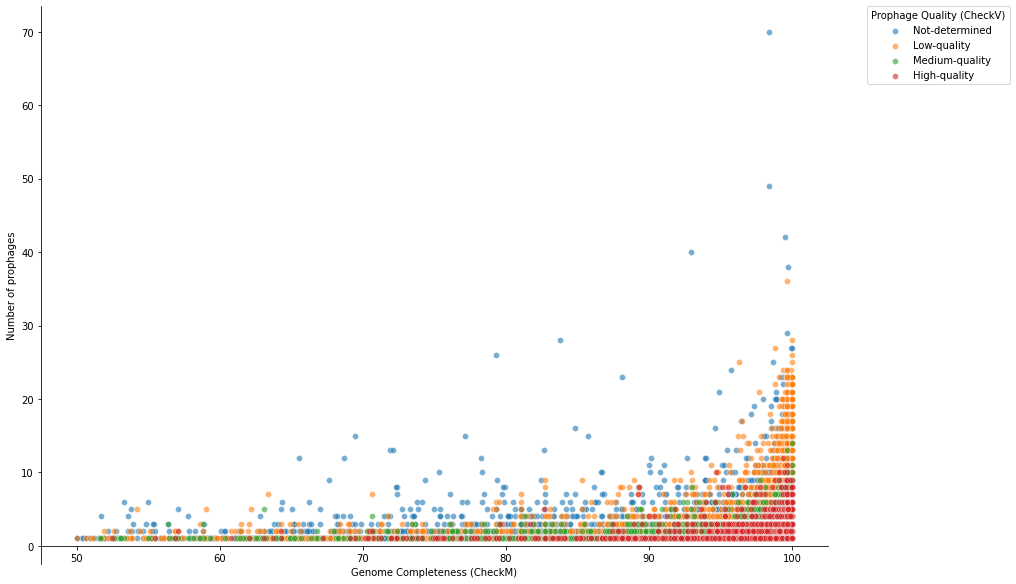

In [16]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))
for c in ['Not-determined', 'Low-quality', 'Medium-quality', 'High-quality']:
    sns.scatterplot(x='checkm_completeness', y=c, data=checkmv, marker='o', ax=ax, label=c, alpha=0.6)

ax.set_ylabel('Number of prophages')
ax.set_xlabel('Genome Completeness (CheckM)')
ax.spines['bottom'].set_position('zero')
#ax.spines['left'].set_position('zero')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


plt.tight_layout()
l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
l.set_title("Prophage Quality (CheckV)")

# Taxonomy

Extract the taxonomy from the GTDB table

### Split the taxonomy into separate columns

We split on `_` but unfortunately the `_` means something specific in GTDB. This is taken from the [FAQ](https://gtdb.ecogenomic.org/faq)
> If the organism had been assigned a binomial species name such as Prevotella oralitaxus str. F0040, and it is not part of true Prevotella in GTDB, we would assign it to the placeholder genus g__Prevotella_A to indicate it is not a true Prevotella species, but that there are representative genomes that have been assigned to a species

We at least remove the `g__` at the beginning and then leave the appendages.

In [17]:
s = re.compile('^.__')
# u = re.compile('_')
def split_taxonomy(x):
    p  = x.split(';')
    if len(p) != 7:
        sys.stderr.write("We have {len(p)} fields in {x}, but we expected 7 fields")
    # remove the prepended taxonomic rank name (e.g d__) and any remaining underscores before returning.
    # return [u.sub(' ', l) for l in [s.sub('', m) for m in p] ]
    return [s.sub('', m) for m in p]

In [18]:
# this is an example to make sure the split looks good. Returns an array
split_taxonomy(gtdb['gtdb_taxonomy'].iloc[0])

['Bacteria',
 'Firmicutes',
 'Bacilli',
 'Bacillales',
 'Bacillaceae_G',
 'Bacillus_A',
 'Bacillus_A anthracis']

In [19]:
tc = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
gc = ['accession', 'gtdb_genome_representative', 'gtdb_representative', 'gtdb_taxonomy', 'gtdb_type_designation', 'gtdb_type_designation_sources', 'gtdb_type_species_of_genus']
gtdbex = pd.concat([gtdb[acccol], pd.DataFrame.from_records(gtdb['gtdb_taxonomy'].apply(split_taxonomy), columns=tc), gtdb[gc]], axis=1)
gtdbex

,assembly_accession,domain,phylum,class,order,family,genus,species,accession,gtdb_genome_representative,gtdb_representative,gtdb_taxonomy,gtdb_type_designation,gtdb_type_designation_sources,gtdb_type_species_of_genus
0,GCA_000006155.2,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae_G,Bacillus_A,Bacillus_A anthracis,GB_GCA_000006155.2,RS_GCF_000534935.2,f,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,not type material,none,f
1,GCA_000007385.1,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xanthomonas,Xanthomonas oryzae,GB_GCA_000007385.1,RS_GCF_004136375.1,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,not type material,none,f
2,GCA_000008605.1,Bacteria,Spirochaetota,Spirochaetia,Treponematales,Treponemataceae,Treponema,Treponema pallidum,GB_GCA_000008605.1,RS_GCF_000410535.2,f,d__Bacteria;p__Spirochaetota;c__Spirochaetia;o...,not type material,none,f
3,GCA_000010565.1,Bacteria,Firmicutes_B,Desulfotomaculia,Desulfotomaculales,Pelotomaculaceae,Pelotomaculum,Pelotomaculum thermopropionicum,GB_GCA_000010565.1,GB_GCA_000010565.1,t,d__Bacteria;p__Firmicutes_B;c__Desulfotomaculi...,type strain of species,LPSN; DSMZ; StrainInfo,t
4,GCA_000013845.2,Bacteria,Firmicutes_A,Clostridia,Clostridiales,Clostridiaceae,Clostridium_P,Clostridium_P perfringens,GB_GCA_000013845.2,RS_GCF_000013285.1,f,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__C...,not type material,none,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191522,GCA_902166935.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella,Klebsiella pneumoniae,RS_GCF_902166935.1,RS_GCF_000742135.1,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,not type material,none,f
191523,GCA_902166945.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella,Klebsiella pneumoniae,RS_GCF_902166945.1,RS_GCF_000742135.1,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,not type material,none,f
191524,GCA_902167295.1,Bacteria,Bacteroidota,Bacteroidia,Chitinophagales,Chitinophagaceae,Chitinophaga,Chitinophaga pinensis_A,RS_GCF_902167295.1,RS_GCF_902167325.1,f,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,not type material,none,f
191525,GCA_902167305.1,Bacteria,Bacteroidota,Bacteroidia,Chitinophagales,Chitinophagaceae,Chitinophaga,Chitinophaga pinensis_A,RS_GCF_902167305.1,RS_GCF_902167325.1,f,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,not type material,none,f


### Do we need to combine to different levels

We can combined e.g. from Bacteria to Order. But do we need to?

In [20]:
toorder = len(pd.unique(gtdbex.apply(lambda x: '_'.join(x[1:5].values.tolist()), axis=1)))
uniqueorder = len(pd.unique(gtdbex['order']))
print(f"Unique orders: {uniqueorder} Unique to order: {toorder}")

Unique orders: 930 Unique to order: 930


[According to Donovan, they should be unique](https://forum.gtdb.ecogenomic.org/t/uniqueness-of-names-across-the-taxonomy/137) so we don't need to merge the columns! 

## Merge the data frames

Merge the GTDB taxonomy with the prophage counts into a single df

In [57]:
cvtax = pd.merge(gtdbex[['assembly_accession', 'domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']], checkvcounts, left_on='assembly_accession', right_on='assembly_accession', how='inner')
cvtax = pd.merge(cvtax, phagesdf[['assembly_accession', 'Kept']], left_on='assembly_accession', right_on='assembly_accession', how='inner')
cvtax

,assembly_accession,domain,phylum,class,order,family,genus,species,Not-determined,Low-quality,Medium-quality,High-quality,Complete,Kept
0,GCA_000007385.1,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xanthomonas,Xanthomonas oryzae,2.0,1.0,1.0,NaN,NaN,4
1,GCA_000008605.1,Bacteria,Spirochaetota,Spirochaetia,Treponematales,Treponemataceae,Treponema,Treponema pallidum,NaN,1.0,NaN,NaN,NaN,1
2,GCA_000010565.1,Bacteria,Firmicutes_B,Desulfotomaculia,Desulfotomaculales,Pelotomaculaceae,Pelotomaculum,Pelotomaculum thermopropionicum,1.0,NaN,NaN,1.0,NaN,2
3,GCA_000013845.2,Bacteria,Firmicutes_A,Clostridia,Clostridiales,Clostridiaceae,Clostridium_P,Clostridium_P perfringens,1.0,NaN,1.0,NaN,NaN,2
4,GCA_000014305.1,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus suis,3.0,1.0,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63601,GCA_901472525.1,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Burkholderiaceae,Bordetella,Bordetella pertussis,NaN,2.0,NaN,NaN,NaN,2
63602,GCA_901472535.1,Bacteria,Bacteroidota,Bacteroidia,Sphingobacteriales,Sphingobacteriaceae,Sphingobacterium,Sphingobacterium daejeonense,5.0,2.0,2.0,NaN,NaN,9
63603,GCA_901472545.1,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Pseudomonas aeruginosa,NaN,3.0,1.0,3.0,NaN,7
63604,GCA_901472575.1,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus equi,1.0,1.0,NaN,1.0,NaN,3


In [32]:
for c in ['Not-determined', 'Low-quality', 'Medium-quality', 'High-quality']:
    print(cvtax[c].mean())

2.025853061468191
2.741112828438949
1.7544734046899257
1.5608648815020005


### Make a plot

This makes a plot of the data, and sets the labels to be readable.

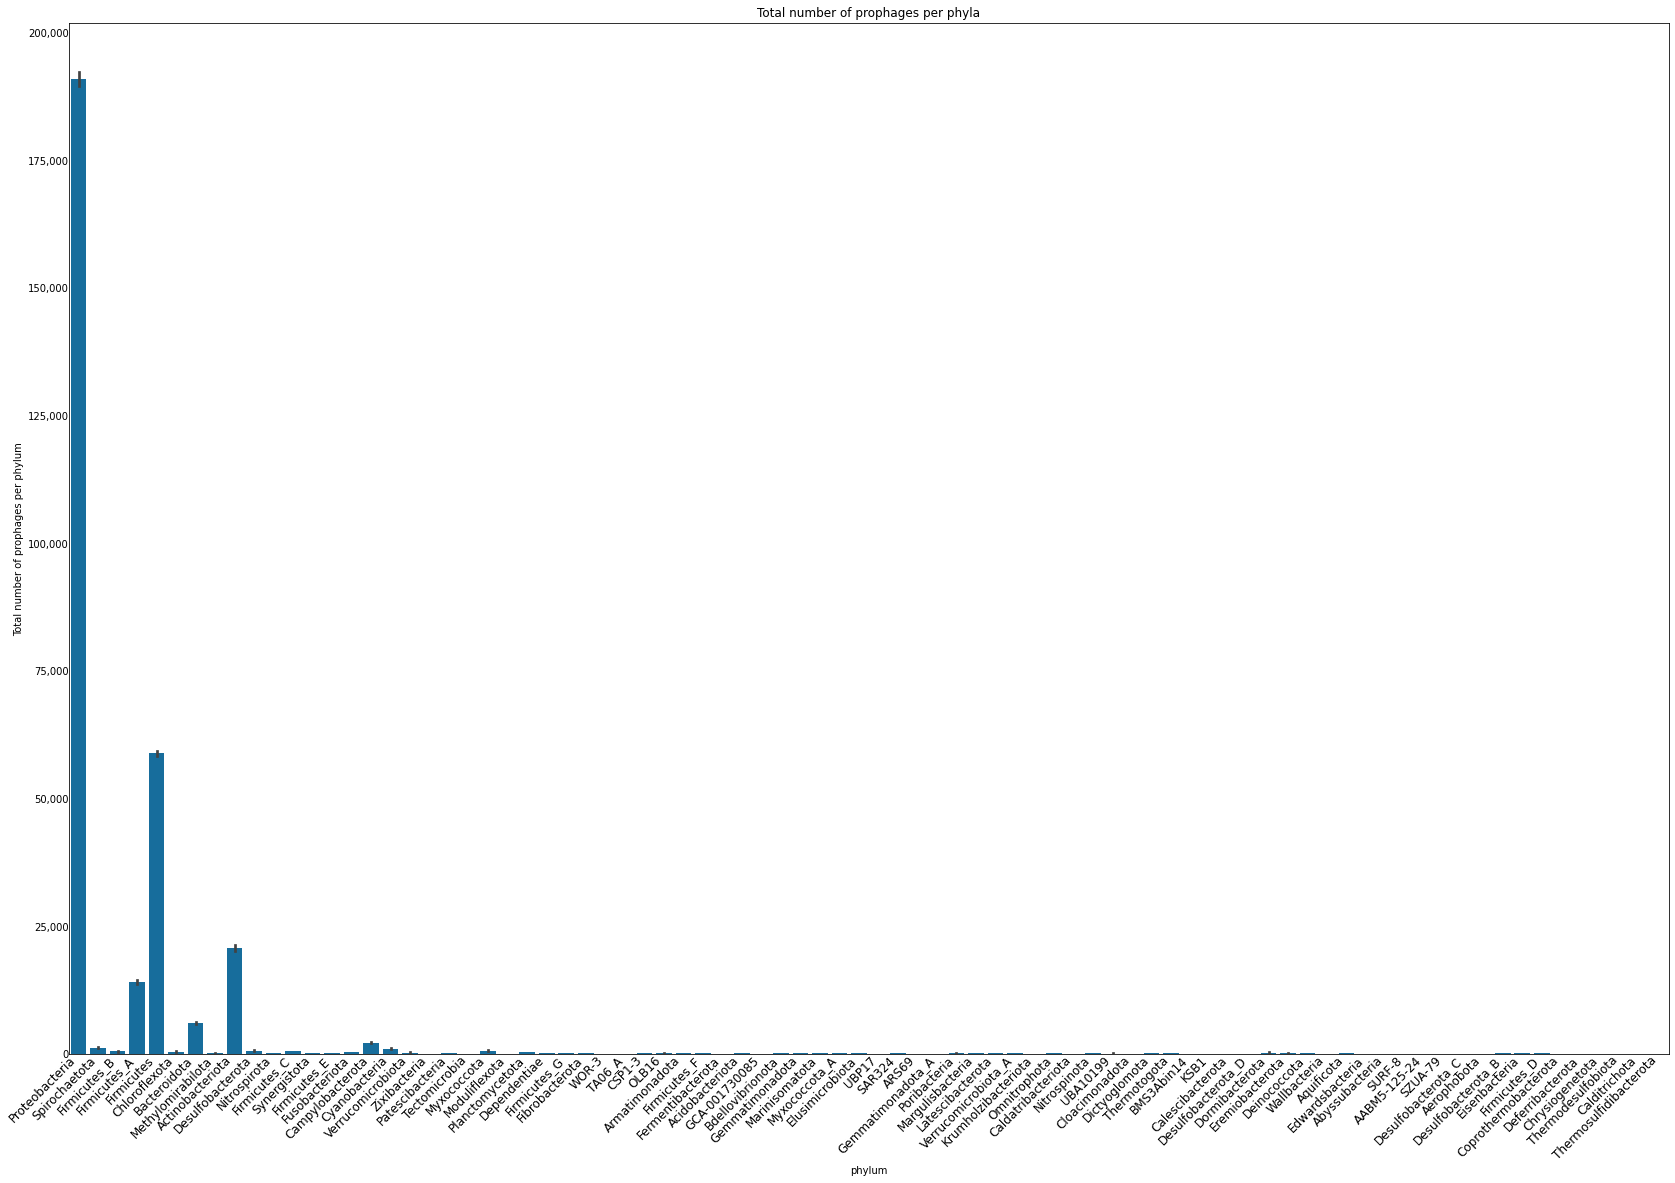

In [62]:
fig, ax = plt.subplots(1,1, figsize=(23.4,16.54), sharey=True)
sns.barplot(x='phylum', y='Kept', data=cvtax, ax=ax, label=c, color=sns.color_palette("colorblind")[0], estimator=sum)

# get the tick labels and change some parameters about them.
ticks_loc = ax.get_xticklabels()
l = ax.set_xticklabels(ticks_loc, rotation=45, horizontalalignment='right', fontsize=12)

ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x,p: format(int(x), ',')))
                                   
ax.set_title(f"Total number of prophages per phyla")

# add a slight offset for every other tick label
"""
for alab in l[::2]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))
"""

# turn off the ticks themselves
ax.tick_params(length=0, pad=0)
ax.set_ylabel('Total number of prophages per phylum')
plt.tight_layout()
fig.savefig('images/phylaTotal.svg')

In [77]:
tx = "**Fig. S\*\* Phages predicted per bacterial phyla.** Most of the predictions are from"
for idx, row in cvtax.groupby('phylum').sum().sort_values(by='Kept', ascending=False).head(5).iterrows():
    tx += f" {idx} ({int(row['Kept']):,} phages),"
printmd(tx)


<span style='color:black'>**Fig. S\*\* Phages predicted per bacterial phyla.** Most of the predictions are from Proteobacteria (190,804 phages), Firmicutes (58,761 phages), Actinobacteriota (20,665 phages), Firmicutes_A (13,973 phages), Bacteroidota (6,043 phages),</span>

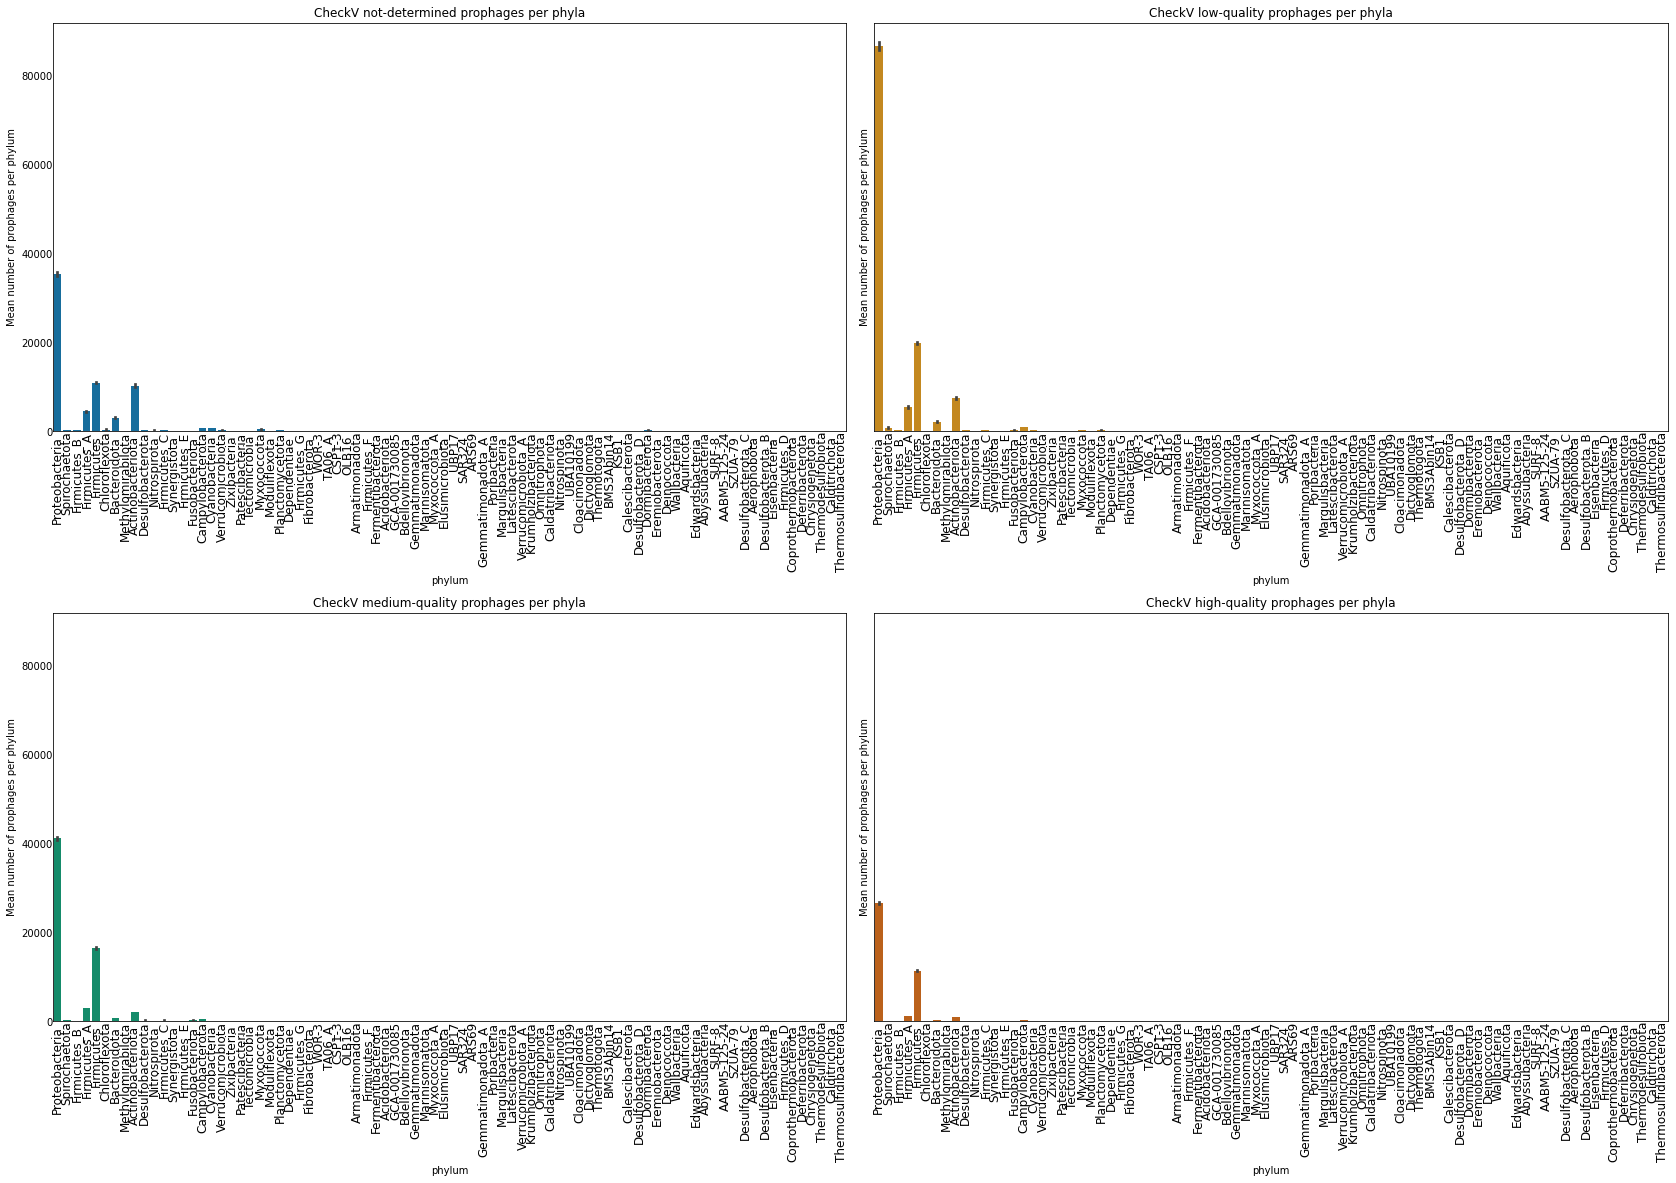

In [54]:
fig, axes = plt.subplots(2,2, figsize=(23.4,16.54), sharey=True)

col =  [['Not-determined', 'Low-quality'], ['Medium-quality', 'High-quality']]

for i in 0, 1:
    for j in 0, 1:
        c = col[i][j]
        ax = axes[i][j]
        sns.barplot(x='phylum', y=c, data=cvtax, ax=ax, label=c, color=sns.color_palette("colorblind")[(2*i) + j], estimator=sum)

        # get the tick labels and change some parameters about them.
        ticks_loc = ax.get_xticklabels()
        l = ax.set_xticklabels(ticks_loc, rotation=90, horizontalalignment='center', fontsize=12)
        # use this to hide every other tick
        # [x.set_visible(False) for x in l[::2]]

        ax.set_title(f"CheckV {c.lower()} prophages per phyla")
        # add a slight offset for every other tick label
        for alab in l[::2]:
            x, y = alab.get_position()
            alab.set_position((x, y-0.01))

        # turn off the ticks themselves
        ax.tick_params(length=0, pad=0)
        ax.set_ylabel('Mean number of prophages per phylum')
plt.tight_layout()
fig.savefig('images/phyla.svg')


<div style="background-color:lightyellow">

    
<h1>Statistical Analyses</h1>
    

Some stats on the number of prophages per taxonomic classification
    </div>

# Effect Size Calculations

Our datasets are so large that even small effect sizes may have statistically significant differences. There is lots of discussion about this, for example see these posts and articles:

* [Effect size, confidence interval and statistical significance: a practical guide for biologists](https://people.kth.se/~lang/Effect_size.pdf)
* [It's the Effect Size, Stupid! What effect size is and why it is important](http://www.leeds.ac.uk/educol/documents/00002182.htm)
* [Large scale statistical analysis discussion on stats stackexchange](https://stats.stackexchange.com/questions/7815/what-skills-are-required-to-perform-large-scale-statistical-analyses)
* [Large data sets and hypothesis testing](https://stats.stackexchange.com/questions/2516/are-large-data-sets-inappropriate-for-hypothesis-testing)
* [The Dangers of Large Data Sets: A Tale of P values, Error Rates, and Bonferroni Corrections](https://thelogicofscience.com/2015/04/07/basic-statistics-part-3-the-dangers-of-large-data-sets-a-tale-of-p-values-error-rates-and-bonferroni-corrections/)
* [The Unofficial Google Data Blog](http://www.unofficialgoogledatascience.com/2016/10/practical-advice-for-analysis-of-large.html)

Because of these concerns, we include two measures of effect size.

## Cohen's f<sup>2</sup>

This is a measure of the effect size from the ANOVA:

f<sup>2</sup> = &#x003B7;<sup>2</sup>/(1 - &#x003B7;<sup>2</sup>)

This measures the combined effect size, and does not provide a pairwise comparison of the data.

According to Cohen (1988; pg. 413; Chapter 9) the effect sizes are: 

 * small effect size: f<sup>2</sup> = 0.02
 * medium effect size: f<sup>2</sup> = 0.15
 * large effect size: f<sup>2</sup> = 0.35

See chapter 9 of [Cohen J. E. (1988). Statistical Power Analysis for the Behavioral Sciences. Hillsdale, NJ: Lawrence Erlbaum Associates, Inc](http://www.utstat.toronto.edu/~brunner/oldclass/378f16/readings/CohenPower.pdf)

# Cohen's d

This is a pairwise measure of the effect size, and can be used to compare our different groups or samples thereof.

According to Cohen (1988; pg. 26; Chapter 2) the effect sizes are:

 * small effect size: d = 0.2
 * medium effect size: d = 0.5
 * large effect size: d = 0.8
 
For a detailed exposition, see chapter 2 of [Cohen J. E. (1988). Statistical Power Analysis for the Behavioral Sciences. Hillsdale, NJ: Lawrence Erlbaum Associates, Inc](http://www.utstat.toronto.edu/~brunner/oldclass/378f16/readings/CohenPower.pdf)

In [78]:
def cohen_f(ssr,sse):
    """
    Calculate Cohen's f-squared from the Sum of Squares of Regression (SSR)
    and the Sum of Squares of Error (SSE).
    
    SSR is from the anova table as aov_table['sum_sq'][0]
    SSE is from the anova table as aov_table['sum_sq'][1]
    """
    
    rsq = ssr / (ssr + sse) # R^2 = SSR/SST
    return rsq / (1-rsq)

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    if np.isnan(d):
        # sys.stderr.write(f"{x} ~ {y} returned NaN\n")
        return 0
    return d

# Make sure the data is the same.

We are going to check the number of contigs, the number of basepairs

In [85]:
print("Phylum\tMinimum number of prophages\tMaximum number of prophages\tMean number of prophages\tMedian number of prophages\tStandard deviation")
for p in sorted(pd.unique(cvtax['phylum'])):
    d = cvtax[cvtax['phylum'] == p]
    count = d.Kept.count()
    m = d.Kept.min()
    x = d.Kept.max()
    n = round(d.Kept.mean(), 2)
    e = round(d.Kept.median(), 2)
    s = round(d.Kept.std(), 2)
    if np.isnan(s):
        s = ""
    print("\t".join(map(str, [p, m, x, n, e, s])))

Phylum	Minimum number of prophages	Maximum number of prophages	Mean number of prophages	Median number of prophages	Standard deviation
AABM5-125-24	2	2	2.0	2.0	0.0
ARS69	1	1	1.0	1.0	
Abyssubacteria	2	2	2.0	2.0	
Acidobacteriota	1	11	2.67	2.0	2.15
Actinobacteriota	1	74	3.53	3.0	3.44
Aerophobota	1	1	1.0	1.0	
Aquificota	1	4	1.9	2.0	0.88
Armatimonadota	1	5	3.0	3.0	1.83
BMS3Abin14	3	3	3.0	3.0	
Bacteroidota	1	18	3.14	2.0	2.43
Bdellovibrionota	1	8	1.6	1.0	1.48
CSP1-3	1	3	1.5	1.0	0.84
Caldatribacteriota	1	1	1.0	1.0	0.0
Calditrichota	2	2	2.0	2.0	
Calescibacterota	3	3	3.0	3.0	
Campylobacterota	1	7	1.83	2.0	0.95
Chloroflexota	1	34	3.01	2.0	4.38
Chrysiogenetota	2	2	2.0	2.0	
Cloacimonadota	1	1	1.0	1.0	0.0
Coprothermobacterota	1	1	1.0	1.0	
Cyanobacteria	1	16	3.28	2.5	2.45
Deferribacterota	1	1	1.0	1.0	
Deinococcota	1	8	2.38	2.0	1.76
Dependentiae	1	8	2.5	1.0	2.81
Desulfobacterota	1	14	3.12	3.0	2.05
Desulfobacterota_B	2	7	3.67	2.0	2.89
Desulfobacterota_C	1	1	1.0	1.0	
Desulfobacterota_D	1	1	1.0	1.0	
Dicty

# Anovas

I've used two different ways to calculate the ANOVA. The first is using _scipy.stats_ function _f\_oneway_ and the second is with statsmodels

### Calculate the one-way anova for all the data

Here, we group by _to_phylum_ and then compare the number of prophages in each group. Note that _group\_by_ returns a tuple of the grouped by name and the dataframe for that group, so _names_ is an array of the names and has the same dimension as _samples_. The 2D array _samples_ has one dimension for each name and the other for the number of prophages for that name.

In [96]:
samples = []
names = []
for nm, groupdf in cvtax.groupby('phylum'):
    names.append(nm)
    samples.append(groupdf['Kept'])
f_val, p_val = f_oneway(*samples)
print('F value: {:.3f}, p value: {:.3f}'.format(f_val, p_val))

F value: 105.244, p value: 0.000


### Repeat for order

Is there a significant difference in order

In [97]:
samples = []
names = []
for nm, groupdf in cvtax.groupby('order'):
    names.append(nm)
    samples.append(groupdf['Kept'])
f_val, p_val = f_oneway(*samples)
print('F value: {:.3f}, p value: {:.3f}'.format(f_val, p_val))

F value: 40.929, p value: 0.000


### Using statsmodels

Here we make a regression model on phylum.


In [102]:
mod = ols('Kept ~ phylum', data=cvtax).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
print()
printmd("Report as: *F*({}, {:,}) = {}, *p* = {}".format(
    int(aov_table.df['phylum']), 
    int(aov_table.df['Residual']),
    round(aov_table.F['phylum'], 2),
    round(aov_table.get("PR(>F)")['phylum'], 4)
))

                 sum_sq       df           F  PR(>F)
phylum     97274.164017     81.0  105.243915     0.0
Residual  724858.660245  63524.0         NaN     NaN



<span style='color:black'>Report as: *F*(81, 63,524) = 105.24, *p* = 0.0</span>

In [103]:
mod = ols('Kept ~ order', data=cvtax).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
print()
printmd("Report as: *F*({}, {:,}) = {}, *p* = {}".format(
    int(aov_table.df['order']), 
    int(aov_table.df['Residual']),
    round(aov_table.F['order'], 2),
    round(aov_table.get("PR(>F)")['order'], 4)
))

                 sum_sq       df          F  PR(>F)
order     191366.788017    468.0  40.929492     0.0
Residual  630766.036237  63137.0        NaN     NaN



<span style='color:black'>Report as: *F*(468, 63,137) = 40.93, *p* = 0.0</span>

### Use Tukey's honestly significant difference test to compare the data

This performs pairwise comparisons on our data. The NULL hypothesis is that there is no statistical difference in the means of the two samples. If we reject that NULL hypothesis (reject == True) then we have reason to believe that there is a significan difference in the means of the samples.

In [105]:
rec = pairwise_tukeyhsd(cvtax['Kept'], cvtax['phylum'])
print(rec)

                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                 group2         meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------------------------
          AABM5-125-24                  ARS69     -1.0    0.9 -18.4425 16.4425  False
          AABM5-125-24         Abyssubacteria      0.0    0.9 -17.4425 17.4425  False
          AABM5-125-24        Acidobacteriota   0.6667    0.9  -9.6407 10.9741  False
          AABM5-125-24       Actinobacteriota   1.5283    0.9  -8.5439 11.6004  False
          AABM5-125-24            Aerophobota     -1.0    0.9 -18.4425 16.4425  False
          AABM5-125-24             Aquificota     -0.1    0.9 -11.1316 10.9316  False
          AABM5-125-24         Armatimonadota      1.0    0.9 -11.3337 13.3337  False
          AABM5-125-24             BMS3Abin14      1.0    0.9 -16.4425 18.4425  False
          AABM5-125-24           Bacteroidota   1.1376

In [106]:
tukeysres = pd.DataFrame(data=rec._results_table.data[1:], columns=rec._results_table.data[0])
tukeysres[tukeysres['reject'] == True]

,group1,group2,meandiff,p-adj,lower,upper,reject
273,Acidobacteriota,Firmicutes_A,2.6870,0.0010,0.4718,4.9021,True
291,Acidobacteriota,Myxococcota,2.8433,0.0116,0.2247,5.4620,True
300,Acidobacteriota,Proteobacteria,3.1269,0.0010,0.9279,5.3258,True
322,Actinobacteriota,Bacteroidota,-0.3907,0.0242,-0.7648,-0.0166,True
328,Actinobacteriota,Campylobacterota,-1.7000,0.0010,-2.1551,-1.2449,True
...,...,...,...,...,...,...,...
3132,Planctomycetota,Proteobacteria,2.8292,0.0010,1.4812,4.1772,True
3171,Proteobacteria,Spirochaetota,-3.3066,0.0010,-3.9752,-2.6379,True
3172,Proteobacteria,Synergistota,-3.9185,0.0010,-6.8267,-1.0104,True
3177,Proteobacteria,Thermotogota,-4.6735,0.0010,-7.5229,-1.8241,True


## Effect size

We measure the effect size of the group as a whole from the anova using Cohen's f<sup>2</sup> and pairwise using Cohen's d.

In [107]:
phyla = pd.unique(cvtax['phylum'])
for i, c in enumerate(phyla):
    for j in range(i, len(phyla)):
        d = phyla[j]
        if c == d:
            continue
        print("Cohen's d for {} - {}: {}".format(c, d, round(
            cohen_d(
                cvtax[cvtax['phylum'] == c]['Kept'], cvtax[cvtax['phylum'] == d]['Kept'], 
        ), 2)))

Cohen's d for Proteobacteria - Spirochaetota: 0.82
Cohen's d for Proteobacteria - Firmicutes_B: 0.47
Cohen's d for Proteobacteria - Firmicutes_A: 0.11
Cohen's d for Proteobacteria - Firmicutes: 0.66
Cohen's d for Proteobacteria - Chloroflexota: 0.69
Cohen's d for Proteobacteria - Bacteroidota: 0.67
Cohen's d for Proteobacteria - Methylomirabilota: 0.94
Cohen's d for Proteobacteria - Actinobacteriota: 0.57
Cohen's d for Proteobacteria - Desulfobacterota: 0.66
Cohen's d for Proteobacteria - Nitrospirota: 0.82
Cohen's d for Proteobacteria - Firmicutes_C: 0.62
Cohen's d for Proteobacteria - Synergistota: 0.97
Cohen's d for Proteobacteria - Firmicutes_E: 0.59
Cohen's d for Proteobacteria - Fusobacteriota: 0.66
Cohen's d for Proteobacteria - Campylobacterota: 1.0
Cohen's d for Proteobacteria - Cyanobacteria: 0.63
Cohen's d for Proteobacteria - Verrucomicrobiota: 1.0
Cohen's d for Proteobacteria - Zixibacteria: 0
Cohen's d for Proteobacteria - Patescibacteria: 1.16
Cohen's d for Proteobacteri

Cohen's d for Firmicutes_B - Tectomicrobia: 0
Cohen's d for Firmicutes_B - Myxococcota: -0.43
Cohen's d for Firmicutes_B - Moduliflexota: 0.94
Cohen's d for Firmicutes_B - Planctomycetota: 0.39
Cohen's d for Firmicutes_B - Dependentiae: 0.55
Cohen's d for Firmicutes_B - Firmicutes_G: 0.82
Cohen's d for Firmicutes_B - Fibrobacterota: 0.72
Cohen's d for Firmicutes_B - WOR-3: 0.94
Cohen's d for Firmicutes_B - TA06_A: 0
Cohen's d for Firmicutes_B - CSP1-3: 0.96
Cohen's d for Firmicutes_B - OLB16: 0.16
Cohen's d for Firmicutes_B - Armatimonadota: 0.36
Cohen's d for Firmicutes_B - Firmicutes_F: 0.28
Cohen's d for Firmicutes_B - Fermentibacterota: 1.14
Cohen's d for Firmicutes_B - Acidobacteriota: 0.51
Cohen's d for Firmicutes_B - GCA-001730085: 0
Cohen's d for Firmicutes_B - Bdellovibrionota: 0.98
Cohen's d for Firmicutes_B - Gemmatimonadota: 1.02
Cohen's d for Firmicutes_B - Marinisomatota: 1.23
Cohen's d for Firmicutes_B - Myxococcota_A: 0.83
Cohen's d for Firmicutes_B - Elusimicrobiota: 1

Cohen's d for Firmicutes - Gemmatimonadota: 1.07
Cohen's d for Firmicutes - Marinisomatota: 1.2
Cohen's d for Firmicutes - Myxococcota_A: 0.86
Cohen's d for Firmicutes - Elusimicrobiota: 1.13
Cohen's d for Firmicutes - UBP17: 0
Cohen's d for Firmicutes - SAR324: 0.69
Cohen's d for Firmicutes - ARS69: 0
Cohen's d for Firmicutes - Gemmatimonadota_A: 0
Cohen's d for Firmicutes - Poribacteria: 1.03
Cohen's d for Firmicutes - Margulisbacteria: 1.29
Cohen's d for Firmicutes - Latescibacterota: 1.08
Cohen's d for Firmicutes - Verrucomicrobiota_A: 0.78
Cohen's d for Firmicutes - Krumholzibacteriota: 0
Cohen's d for Firmicutes - Omnitrophota: 1.03
Cohen's d for Firmicutes - Caldatribacteriota: 1.29
Cohen's d for Firmicutes - Nitrospinota: 1.08
Cohen's d for Firmicutes - UBA10199: 0.78
Cohen's d for Firmicutes - Cloacimonadota: 1.29
Cohen's d for Firmicutes - Dictyoglomota: 0.65
Cohen's d for Firmicutes - Thermotogota: 1.23
Cohen's d for Firmicutes - BMS3Abin14: 0
Cohen's d for Firmicutes - KSB1

Cohen's d for Bacteroidota - Dormibacterota: -0.29
Cohen's d for Bacteroidota - Eremiobacterota: 0.68
Cohen's d for Bacteroidota - Deinococcota: 0.32
Cohen's d for Bacteroidota - Wallbacteria: 0
Cohen's d for Bacteroidota - Aquificota: 0.51
Cohen's d for Bacteroidota - Edwardsbacteria: 0
Cohen's d for Bacteroidota - Abyssubacteria: 0
Cohen's d for Bacteroidota - SURF-8: 0
Cohen's d for Bacteroidota - AABM5-125-24: 0.47
Cohen's d for Bacteroidota - SZUA-79: 0.47
Cohen's d for Bacteroidota - Desulfobacterota_C: 0
Cohen's d for Bacteroidota - Aerophobota: 0
Cohen's d for Bacteroidota - Desulfobacterota_B: -0.22
Cohen's d for Bacteroidota - Eisenbacteria: 0.47
Cohen's d for Bacteroidota - Firmicutes_D: -0.15
Cohen's d for Bacteroidota - Coprothermobacterota: 0
Cohen's d for Bacteroidota - Deferribacterota: 0
Cohen's d for Bacteroidota - Chrysiogenetota: 0
Cohen's d for Bacteroidota - Thermodesulfobiota: 0
Cohen's d for Bacteroidota - Calditrichota: 0
Cohen's d for Bacteroidota - Thermosulf

Cohen's d for Actinobacteriota - Eisenbacteria: 0.44
Cohen's d for Actinobacteriota - Firmicutes_D: 0.01
Cohen's d for Actinobacteriota - Coprothermobacterota: 0
Cohen's d for Actinobacteriota - Deferribacterota: 0
Cohen's d for Actinobacteriota - Chrysiogenetota: 0
Cohen's d for Actinobacteriota - Thermodesulfobiota: 0
Cohen's d for Actinobacteriota - Calditrichota: 0
Cohen's d for Actinobacteriota - Thermosulfidibacterota: 0
Cohen's d for Desulfobacterota - Nitrospirota: 0.33
Cohen's d for Desulfobacterota - Firmicutes_C: -0.08
Cohen's d for Desulfobacterota - Synergistota: 0.64
Cohen's d for Desulfobacterota - Firmicutes_E: -0.15
Cohen's d for Desulfobacterota - Fusobacteriota: 0.0
Cohen's d for Desulfobacterota - Campylobacterota: 1.11
Cohen's d for Desulfobacterota - Cyanobacteria: -0.07
Cohen's d for Desulfobacterota - Verrucomicrobiota: 0.76
Cohen's d for Desulfobacterota - Zixibacteria: 0
Cohen's d for Desulfobacterota - Patescibacteria: 1.21
Cohen's d for Desulfobacterota - Te

Cohen's d for Firmicutes_C - Myxococcota_A: 0.61
Cohen's d for Firmicutes_C - Elusimicrobiota: 0.84
Cohen's d for Firmicutes_C - UBP17: 0
Cohen's d for Firmicutes_C - SAR324: 0.47
Cohen's d for Firmicutes_C - ARS69: 0
Cohen's d for Firmicutes_C - Gemmatimonadota_A: 0
Cohen's d for Firmicutes_C - Poribacteria: 0.74
Cohen's d for Firmicutes_C - Margulisbacteria: 0.95
Cohen's d for Firmicutes_C - Latescibacterota: 0.78
Cohen's d for Firmicutes_C - Verrucomicrobiota_A: 0.54
Cohen's d for Firmicutes_C - Krumholzibacteriota: 0
Cohen's d for Firmicutes_C - Omnitrophota: 0.76
Cohen's d for Firmicutes_C - Caldatribacteriota: 0.94
Cohen's d for Firmicutes_C - Nitrospinota: 0.78
Cohen's d for Firmicutes_C - UBA10199: 0.53
Cohen's d for Firmicutes_C - Cloacimonadota: 0.94
Cohen's d for Firmicutes_C - Dictyoglomota: 0.43
Cohen's d for Firmicutes_C - Thermotogota: 0.95
Cohen's d for Firmicutes_C - BMS3Abin14: 0
Cohen's d for Firmicutes_C - KSB1: 0.73
Cohen's d for Firmicutes_C - Calescibacterota: 0


Cohen's d for Firmicutes_E - Firmicutes_D: -0.03
Cohen's d for Firmicutes_E - Coprothermobacterota: 0
Cohen's d for Firmicutes_E - Deferribacterota: 0
Cohen's d for Firmicutes_E - Chrysiogenetota: 0
Cohen's d for Firmicutes_E - Thermodesulfobiota: 0
Cohen's d for Firmicutes_E - Calditrichota: 0
Cohen's d for Firmicutes_E - Thermosulfidibacterota: 0
Cohen's d for Fusobacteriota - Campylobacterota: 1.23
Cohen's d for Fusobacteriota - Cyanobacteria: -0.07
Cohen's d for Fusobacteriota - Verrucomicrobiota: 0.88
Cohen's d for Fusobacteriota - Zixibacteria: 0
Cohen's d for Fusobacteriota - Patescibacteria: 1.49
Cohen's d for Fusobacteriota - Tectomicrobia: 0
Cohen's d for Fusobacteriota - Myxococcota: -0.68
Cohen's d for Fusobacteriota - Moduliflexota: 0.88
Cohen's d for Fusobacteriota - Planctomycetota: 0.08
Cohen's d for Fusobacteriota - Dependentiae: 0.33
Cohen's d for Fusobacteriota - Firmicutes_G: 0.68
Cohen's d for Fusobacteriota - Fibrobacterota: 0.52
Cohen's d for Fusobacteriota - WOR

Cohen's d for Cyanobacteria - Caldatribacteriota: 0.93
Cohen's d for Cyanobacteria - Nitrospinota: 0.77
Cohen's d for Cyanobacteria - UBA10199: 0.52
Cohen's d for Cyanobacteria - Cloacimonadota: 0.93
Cohen's d for Cyanobacteria - Dictyoglomota: 0.42
Cohen's d for Cyanobacteria - Thermotogota: 0.92
Cohen's d for Cyanobacteria - BMS3Abin14: 0
Cohen's d for Cyanobacteria - KSB1: 0.73
Cohen's d for Cyanobacteria - Calescibacterota: 0
Cohen's d for Cyanobacteria - Desulfobacterota_D: 0
Cohen's d for Cyanobacteria - Dormibacterota: -0.2
Cohen's d for Cyanobacteria - Eremiobacterota: 0.73
Cohen's d for Cyanobacteria - Deinococcota: 0.38
Cohen's d for Cyanobacteria - Wallbacteria: 0
Cohen's d for Cyanobacteria - Aquificota: 0.57
Cohen's d for Cyanobacteria - Edwardsbacteria: 0
Cohen's d for Cyanobacteria - Abyssubacteria: 0
Cohen's d for Cyanobacteria - SURF-8: 0
Cohen's d for Cyanobacteria - AABM5-125-24: 0.52
Cohen's d for Cyanobacteria - SZUA-79: 0.52
Cohen's d for Cyanobacteria - Desulfoba

Cohen's d for Patescibacteria - SAR324: -1.84
Cohen's d for Patescibacteria - ARS69: 0
Cohen's d for Patescibacteria - Gemmatimonadota_A: 0
Cohen's d for Patescibacteria - Poribacteria: -0.75
Cohen's d for Patescibacteria - Margulisbacteria: 0.3
Cohen's d for Patescibacteria - Latescibacterota: -0.54
Cohen's d for Patescibacteria - Verrucomicrobiota_A: -1.37
Cohen's d for Patescibacteria - Krumholzibacteriota: 0
Cohen's d for Patescibacteria - Omnitrophota: -0.66
Cohen's d for Patescibacteria - Caldatribacteriota: 0.3
Cohen's d for Patescibacteria - Nitrospinota: -0.54
Cohen's d for Patescibacteria - UBA10199: -1.74
Cohen's d for Patescibacteria - Cloacimonadota: 0.3
Cohen's d for Patescibacteria - Dictyoglomota: -2.24
Cohen's d for Patescibacteria - Thermotogota: 0.04
Cohen's d for Patescibacteria - BMS3Abin14: 0
Cohen's d for Patescibacteria - KSB1: -0.75
Cohen's d for Patescibacteria - Calescibacterota: 0
Cohen's d for Patescibacteria - Desulfobacterota_D: 0
Cohen's d for Patescibac

Cohen's d for Moduliflexota - Elusimicrobiota: 0.38
Cohen's d for Moduliflexota - UBP17: 0
Cohen's d for Moduliflexota - SAR324: -0.49
Cohen's d for Moduliflexota - ARS69: 0
Cohen's d for Moduliflexota - Gemmatimonadota_A: 0
Cohen's d for Moduliflexota - Poribacteria: 0.0
Cohen's d for Moduliflexota - Margulisbacteria: 1.73
Cohen's d for Moduliflexota - Latescibacterota: 0.17
Cohen's d for Moduliflexota - Verrucomicrobiota_A: -0.33
Cohen's d for Moduliflexota - Krumholzibacteriota: 0
Cohen's d for Moduliflexota - Omnitrophota: 0.0
Cohen's d for Moduliflexota - Caldatribacteriota: 1.0
Cohen's d for Moduliflexota - Nitrospinota: 0.17
Cohen's d for Moduliflexota - UBA10199: -0.45
Cohen's d for Moduliflexota - Cloacimonadota: 1.22
Cohen's d for Moduliflexota - Dictyoglomota: -0.83
Cohen's d for Moduliflexota - Thermotogota: 1.07
Cohen's d for Moduliflexota - BMS3Abin14: 0
Cohen's d for Moduliflexota - KSB1: 0.0
Cohen's d for Moduliflexota - Calescibacterota: 0
Cohen's d for Moduliflexota -

Cohen's d for Firmicutes_G - Gemmatimonadota_A: 0
Cohen's d for Firmicutes_G - Poribacteria: 0.56
Cohen's d for Firmicutes_G - Margulisbacteria: 1.3
Cohen's d for Firmicutes_G - Latescibacterota: 0.69
Cohen's d for Firmicutes_G - Verrucomicrobiota_A: -0.05
Cohen's d for Firmicutes_G - Krumholzibacteriota: 0
Cohen's d for Firmicutes_G - Omnitrophota: 0.51
Cohen's d for Firmicutes_G - Caldatribacteriota: 1.17
Cohen's d for Firmicutes_G - Nitrospinota: 0.69
Cohen's d for Firmicutes_G - UBA10199: -0.07
Cohen's d for Firmicutes_G - Cloacimonadota: 1.21
Cohen's d for Firmicutes_G - Dictyoglomota: -0.36
Cohen's d for Firmicutes_G - Thermotogota: 1.41
Cohen's d for Firmicutes_G - BMS3Abin14: 0
Cohen's d for Firmicutes_G - KSB1: 0.54
Cohen's d for Firmicutes_G - Calescibacterota: 0
Cohen's d for Firmicutes_G - Desulfobacterota_D: 0
Cohen's d for Firmicutes_G - Dormibacterota: -0.39
Cohen's d for Firmicutes_G - Eremiobacterota: 0.52
Cohen's d for Firmicutes_G - Deinococcota: -0.28
Cohen's d for 

Cohen's d for TA06_A - Desulfobacterota_B: 0
Cohen's d for TA06_A - Eisenbacteria: 0
Cohen's d for TA06_A - Firmicutes_D: 0
Cohen's d for TA06_A - Coprothermobacterota: 0
Cohen's d for TA06_A - Deferribacterota: 0
Cohen's d for TA06_A - Chrysiogenetota: 0
Cohen's d for TA06_A - Thermodesulfobiota: 0
Cohen's d for TA06_A - Calditrichota: 0
Cohen's d for TA06_A - Thermosulfidibacterota: 0
Cohen's d for CSP1-3 - OLB16: -1.22
Cohen's d for CSP1-3 - Armatimonadota: -1.15
Cohen's d for CSP1-3 - Firmicutes_F: -1.3
Cohen's d for CSP1-3 - Fermentibacterota: 0.65
Cohen's d for CSP1-3 - Acidobacteriota: -0.57
Cohen's d for CSP1-3 - GCA-001730085: 0
Cohen's d for CSP1-3 - Bdellovibrionota: -0.07
Cohen's d for CSP1-3 - Gemmatimonadota: 0.08
Cohen's d for CSP1-3 - Marinisomatota: 0.63
Cohen's d for CSP1-3 - Myxococcota_A: -0.42
Cohen's d for CSP1-3 - Elusimicrobiota: 0.32
Cohen's d for CSP1-3 - UBP17: 0
Cohen's d for CSP1-3 - SAR324: -0.56
Cohen's d for CSP1-3 - ARS69: 0
Cohen's d for CSP1-3 - Gemma

Cohen's d for Firmicutes_F - Eremiobacterota: 1.27
Cohen's d for Firmicutes_F - Deinococcota: 0.53
Cohen's d for Firmicutes_F - Wallbacteria: 0
Cohen's d for Firmicutes_F - Aquificota: 1.03
Cohen's d for Firmicutes_F - Edwardsbacteria: 0
Cohen's d for Firmicutes_F - Abyssubacteria: 0
Cohen's d for Firmicutes_F - SURF-8: 0
Cohen's d for Firmicutes_F - AABM5-125-24: 0.9
Cohen's d for Firmicutes_F - SZUA-79: 0.9
Cohen's d for Firmicutes_F - Desulfobacterota_C: 0
Cohen's d for Firmicutes_F - Aerophobota: 0
Cohen's d for Firmicutes_F - Desulfobacterota_B: -0.27
Cohen's d for Firmicutes_F - Eisenbacteria: 0.91
Cohen's d for Firmicutes_F - Firmicutes_D: -0.18
Cohen's d for Firmicutes_F - Coprothermobacterota: 0
Cohen's d for Firmicutes_F - Deferribacterota: 0
Cohen's d for Firmicutes_F - Chrysiogenetota: 0
Cohen's d for Firmicutes_F - Thermodesulfobiota: 0
Cohen's d for Firmicutes_F - Calditrichota: 0
Cohen's d for Firmicutes_F - Thermosulfidibacterota: 0
Cohen's d for Fermentibacterota - Aci

<ipython-input-78-643cf20872f7>:17: RuntimeWarning: invalid value encountered in double_scalars
  d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)


Cohen's d for Fermentibacterota - Dictyoglomota: -1.51
Cohen's d for Fermentibacterota - Thermotogota: -0.37
Cohen's d for Fermentibacterota - BMS3Abin14: 0
Cohen's d for Fermentibacterota - KSB1: -1.0
Cohen's d for Fermentibacterota - Calescibacterota: 0
Cohen's d for Fermentibacterota - Desulfobacterota_D: 0
Cohen's d for Fermentibacterota - Dormibacterota: -0.5
Cohen's d for Fermentibacterota - Eremiobacterota: -0.58
Cohen's d for Fermentibacterota - Deinococcota: -0.79
Cohen's d for Fermentibacterota - Wallbacteria: 0
Cohen's d for Fermentibacterota - Aquificota: -1.08
Cohen's d for Fermentibacterota - Edwardsbacteria: 0
Cohen's d for Fermentibacterota - Abyssubacteria: 0
Cohen's d for Fermentibacterota - SURF-8: 0
Cohen's d for Fermentibacterota - AABM5-125-24: -inf
Cohen's d for Fermentibacterota - SZUA-79: -inf


<ipython-input-78-643cf20872f7>:17: RuntimeWarning: divide by zero encountered in double_scalars
  d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)


Cohen's d for Fermentibacterota - Desulfobacterota_C: 0
Cohen's d for Fermentibacterota - Aerophobota: 0
Cohen's d for Fermentibacterota - Desulfobacterota_B: -1.13
Cohen's d for Fermentibacterota - Eisenbacteria: -0.94
Cohen's d for Fermentibacterota - Firmicutes_D: -1.51
Cohen's d for Fermentibacterota - Coprothermobacterota: 0
Cohen's d for Fermentibacterota - Deferribacterota: 0
Cohen's d for Fermentibacterota - Chrysiogenetota: 0
Cohen's d for Fermentibacterota - Thermodesulfobiota: 0
Cohen's d for Fermentibacterota - Calditrichota: 0
Cohen's d for Fermentibacterota - Thermosulfidibacterota: 0
Cohen's d for Acidobacteriota - GCA-001730085: 0
Cohen's d for Acidobacteriota - Bdellovibrionota: 0.56
Cohen's d for Acidobacteriota - Gemmatimonadota: 0.65
Cohen's d for Acidobacteriota - Marinisomatota: 0.92
Cohen's d for Acidobacteriota - Myxococcota_A: 0.41
Cohen's d for Acidobacteriota - Elusimicrobiota: 0.71
Cohen's d for Acidobacteriota - UBP17: 0
Cohen's d for Acidobacteriota - SAR3

Cohen's d for Gemmatimonadota - Dormibacterota: -0.48
Cohen's d for Gemmatimonadota - Eremiobacterota: -0.08
Cohen's d for Gemmatimonadota - Deinococcota: -0.6
Cohen's d for Gemmatimonadota - Wallbacteria: 0
Cohen's d for Gemmatimonadota - Aquificota: -0.55
Cohen's d for Gemmatimonadota - Edwardsbacteria: 0
Cohen's d for Gemmatimonadota - Abyssubacteria: 0
Cohen's d for Gemmatimonadota - SURF-8: 0
Cohen's d for Gemmatimonadota - AABM5-125-24: -0.7
Cohen's d for Gemmatimonadota - SZUA-79: -0.7
Cohen's d for Gemmatimonadota - Desulfobacterota_C: 0
Cohen's d for Gemmatimonadota - Aerophobota: 0
Cohen's d for Gemmatimonadota - Desulfobacterota_B: -1.7
Cohen's d for Gemmatimonadota - Eisenbacteria: -0.6
Cohen's d for Gemmatimonadota - Firmicutes_D: -1.83
Cohen's d for Gemmatimonadota - Coprothermobacterota: 0
Cohen's d for Gemmatimonadota - Deferribacterota: 0
Cohen's d for Gemmatimonadota - Chrysiogenetota: 0
Cohen's d for Gemmatimonadota - Thermodesulfobiota: 0
Cohen's d for Gemmatimonado

Cohen's d for UBP17 - Aquificota: 0
Cohen's d for UBP17 - Edwardsbacteria: 0
Cohen's d for UBP17 - Abyssubacteria: 0
Cohen's d for UBP17 - SURF-8: 0
Cohen's d for UBP17 - AABM5-125-24: 0
Cohen's d for UBP17 - SZUA-79: 0
Cohen's d for UBP17 - Desulfobacterota_C: 0
Cohen's d for UBP17 - Aerophobota: 0
Cohen's d for UBP17 - Desulfobacterota_B: 0
Cohen's d for UBP17 - Eisenbacteria: 0
Cohen's d for UBP17 - Firmicutes_D: 0
Cohen's d for UBP17 - Coprothermobacterota: 0
Cohen's d for UBP17 - Deferribacterota: 0
Cohen's d for UBP17 - Chrysiogenetota: 0
Cohen's d for UBP17 - Thermodesulfobiota: 0
Cohen's d for UBP17 - Calditrichota: 0
Cohen's d for UBP17 - Thermosulfidibacterota: 0
Cohen's d for SAR324 - ARS69: 0
Cohen's d for SAR324 - Gemmatimonadota_A: 0
Cohen's d for SAR324 - Poribacteria: 0.55
Cohen's d for SAR324 - Margulisbacteria: 1.12
Cohen's d for SAR324 - Latescibacterota: 0.66
Cohen's d for SAR324 - Verrucomicrobiota_A: 0.11
Cohen's d for SAR324 - Krumholzibacteriota: 0
Cohen's d for

Cohen's d for Margulisbacteria - SURF-8: 0
Cohen's d for Margulisbacteria - AABM5-125-24: -inf
Cohen's d for Margulisbacteria - SZUA-79: -inf
Cohen's d for Margulisbacteria - Desulfobacterota_C: 0
Cohen's d for Margulisbacteria - Aerophobota: 0
Cohen's d for Margulisbacteria - Desulfobacterota_B: -1.73
Cohen's d for Margulisbacteria - Eisenbacteria: -1.17
Cohen's d for Margulisbacteria - Firmicutes_D: -2.13
Cohen's d for Margulisbacteria - Coprothermobacterota: 0
Cohen's d for Margulisbacteria - Deferribacterota: 0
Cohen's d for Margulisbacteria - Chrysiogenetota: 0
Cohen's d for Margulisbacteria - Thermodesulfobiota: 0
Cohen's d for Margulisbacteria - Calditrichota: 0
Cohen's d for Margulisbacteria - Thermosulfidibacterota: 0
Cohen's d for Latescibacterota - Verrucomicrobiota_A: -0.45
Cohen's d for Latescibacterota - Krumholzibacteriota: 0
Cohen's d for Latescibacterota - Omnitrophota: -0.12
Cohen's d for Latescibacterota - Caldatribacteriota: 0.82
Cohen's d for Latescibacterota - Nit

Cohen's d for Caldatribacteriota - Desulfobacterota_C: 0
Cohen's d for Caldatribacteriota - Aerophobota: 0
Cohen's d for Caldatribacteriota - Desulfobacterota_B: -1.13
Cohen's d for Caldatribacteriota - Eisenbacteria: -0.94
Cohen's d for Caldatribacteriota - Firmicutes_D: -1.51
Cohen's d for Caldatribacteriota - Coprothermobacterota: 0
Cohen's d for Caldatribacteriota - Deferribacterota: 0
Cohen's d for Caldatribacteriota - Chrysiogenetota: 0
Cohen's d for Caldatribacteriota - Thermodesulfobiota: 0
Cohen's d for Caldatribacteriota - Calditrichota: 0
Cohen's d for Caldatribacteriota - Thermosulfidibacterota: 0
Cohen's d for Nitrospinota - UBA10199: -0.75
Cohen's d for Nitrospinota - Cloacimonadota: 0.89
Cohen's d for Nitrospinota - Dictyoglomota: -1.13
Cohen's d for Nitrospinota - Thermotogota: 0.76
Cohen's d for Nitrospinota - BMS3Abin14: 0
Cohen's d for Nitrospinota - KSB1: -0.17
Cohen's d for Nitrospinota - Calescibacterota: 0
Cohen's d for Nitrospinota - Desulfobacterota_D: 0
Cohen'

Cohen's d for KSB1 - SURF-8: 0
Cohen's d for KSB1 - AABM5-125-24: -1.0
Cohen's d for KSB1 - SZUA-79: -1.0
Cohen's d for KSB1 - Desulfobacterota_C: 0
Cohen's d for KSB1 - Aerophobota: 0
Cohen's d for KSB1 - Desulfobacterota_B: -0.91
Cohen's d for KSB1 - Eisenbacteria: -0.45
Cohen's d for KSB1 - Firmicutes_D: -1.18
Cohen's d for KSB1 - Coprothermobacterota: 0
Cohen's d for KSB1 - Deferribacterota: 0
Cohen's d for KSB1 - Chrysiogenetota: 0
Cohen's d for KSB1 - Thermodesulfobiota: 0
Cohen's d for KSB1 - Calditrichota: 0
Cohen's d for KSB1 - Thermosulfidibacterota: 0
Cohen's d for Calescibacterota - Desulfobacterota_D: 0
Cohen's d for Calescibacterota - Dormibacterota: 0
Cohen's d for Calescibacterota - Eremiobacterota: 0
Cohen's d for Calescibacterota - Deinococcota: 0
Cohen's d for Calescibacterota - Wallbacteria: 0
Cohen's d for Calescibacterota - Aquificota: 0
Cohen's d for Calescibacterota - Edwardsbacteria: 0
Cohen's d for Calescibacterota - Abyssubacteria: 0
Cohen's d for Calescibact

Cohen's d for Abyssubacteria - Thermosulfidibacterota: 0
Cohen's d for SURF-8 - AABM5-125-24: 0
Cohen's d for SURF-8 - SZUA-79: 0
Cohen's d for SURF-8 - Desulfobacterota_C: 0
Cohen's d for SURF-8 - Aerophobota: 0
Cohen's d for SURF-8 - Desulfobacterota_B: 0
Cohen's d for SURF-8 - Eisenbacteria: 0
Cohen's d for SURF-8 - Firmicutes_D: 0
Cohen's d for SURF-8 - Coprothermobacterota: 0
Cohen's d for SURF-8 - Deferribacterota: 0
Cohen's d for SURF-8 - Chrysiogenetota: 0
Cohen's d for SURF-8 - Thermodesulfobiota: 0
Cohen's d for SURF-8 - Calditrichota: 0
Cohen's d for SURF-8 - Thermosulfidibacterota: 0
Cohen's d for AABM5-125-24 - SZUA-79: 0
Cohen's d for AABM5-125-24 - Desulfobacterota_C: 0
Cohen's d for AABM5-125-24 - Aerophobota: 0
Cohen's d for AABM5-125-24 - Desulfobacterota_B: -0.71
Cohen's d for AABM5-125-24 - Eisenbacteria: 0.0
Cohen's d for AABM5-125-24 - Firmicutes_D: -0.9
Cohen's d for AABM5-125-24 - Coprothermobacterota: 0
Cohen's d for AABM5-125-24 - Deferribacterota: 0
Cohen's d

Make the effect size into a table so we can make a heat map of it!

In [108]:
phyla = sorted(pd.unique(cvtax['phylum']))
cohend = pd.DataFrame(index=phyla, columns=phyla)
# now that we have created the dataframe, we need to coerce the columns to be numeric. 
for p in phyla:
    cohend[p] = pd.to_numeric(cohend[p])

for i, c in enumerate(phyla):
    for j in range(i, len(phyla)):
        d = phyla[j]
        if c == d:
            cohend.iloc[i, j] = 0
            continue
        cohend.iloc[i, j] = cohen_d(cvtax[cvtax['phylum'] == c]['Kept'], cvtax[cvtax['phylum'] == d]['Kept'])
        cohend.iloc[j, i] = -cohend.iloc[i, j]



<ipython-input-78-643cf20872f7>:17: RuntimeWarning: divide by zero encountered in double_scalars
  d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
<ipython-input-78-643cf20872f7>:17: RuntimeWarning: invalid value encountered in double_scalars
  d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)


In [119]:
cohendnz = cohend.loc[(cohend.sum(axis=1) != 0), (cohend.sum(axis=0) != 0)]
cohendnz

,AABM5-125-24,Acidobacteriota,Actinobacteriota,Aquificota,Armatimonadota,Bacteroidota,Bdellovibrionota,CSP1-3,Caldatribacteriota,Campylobacterota,...,Proteobacteria,SAR324,SZUA-79,Spirochaetota,Synergistota,Thermotogota,UBA10199,Verrucomicrobiota,Verrucomicrobiota_A,WOR-3
AABM5-125-24,0.000000,-0.313993,-0.443895,0.120386,-0.632456,-0.468976,0.275589,0.654654,inf,0.180983,...,-0.940238,-0.124035,0.000000,-0.314198,0.141895,2.708013,0.000000,0.197546,0.000000,1.000000
Acidobacteriota,0.313993,0.000000,-0.250768,0.386995,-0.156608,-0.194528,0.561589,0.569816,0.784982,0.827406,...,-0.775336,0.239692,0.313993,0.111699,0.439182,0.899980,0.312348,0.598921,0.324272,0.548763
Actinobacteriota,0.443895,0.250768,0.000000,0.473240,0.153452,0.121265,0.561160,0.589311,0.734354,0.536936,...,-0.573330,0.395590,0.443895,0.311588,0.481039,0.700857,0.443889,0.512518,0.444128,0.589122
Aquificota,-0.120386,-0.386995,-0.473240,0.000000,-0.926915,-0.511104,0.220879,0.464095,1.083473,0.075629,...,-0.965134,-0.236940,-0.120386,-0.380813,0.027992,1.450699,-0.106000,0.109863,-0.078920,0.464991
Armatimonadota,0.632456,0.156608,-0.153452,0.926915,0.000000,-0.056727,0.925651,1.154701,1.264911,1.229884,...,-0.692399,0.516398,0.632456,0.330258,1.072177,2.747680,0.577350,1.058475,0.612372,0.925820
Bacteroidota,0.468976,0.194528,-0.121265,0.511104,0.056727,0.000000,0.636696,0.675699,0.881230,0.654895,...,-0.670191,0.400491,0.468976,0.284855,0.523042,0.836613,0.468935,0.572367,0.469494,0.675088
Bdellovibrionota,-0.275589,-0.561589,-0.561160,-0.220879,-0.925651,-0.636696,0.000000,0.071396,0.413384,-0.236371,...,-1.039759,-0.384020,-0.275589,-0.573282,-0.219226,0.430660,-0.271329,-0.146648,-0.267136,0.068626
CSP1-3,-0.654654,-0.569816,-0.589311,-0.464095,-1.154701,-0.675699,-0.071396,0.000000,0.654654,-0.345855,...,-1.064225,-0.556846,-0.654654,-0.638564,-0.421860,0.825845,-0.522233,-0.248304,-0.370479,0.000000
Caldatribacteriota,-inf,-0.784982,-0.734354,-1.083473,-1.264911,-0.881230,-0.413384,-0.654654,0.000000,-0.872660,...,-1.188091,-0.868243,-inf,-0.959426,-0.993266,-0.369274,-1.000000,-0.691411,-0.674200,-1.000000
Campylobacterota,-0.180983,-0.827406,-0.536936,-0.075629,-1.229884,-0.654895,0.236371,0.345855,0.872660,0.000000,...,-0.999188,-0.355383,-0.180983,-0.572373,-0.049305,0.752548,-0.180812,0.052237,-0.179741,0.345757


In [133]:
cohenclean = cohendnz.fillna(0).replace(np.inf, 1).replace(-np.inf, -1)
cohenclean

,AABM5-125-24,Acidobacteriota,Actinobacteriota,Aquificota,Armatimonadota,Bacteroidota,Bdellovibrionota,CSP1-3,Caldatribacteriota,Campylobacterota,...,Proteobacteria,SAR324,SZUA-79,Spirochaetota,Synergistota,Thermotogota,UBA10199,Verrucomicrobiota,Verrucomicrobiota_A,WOR-3
AABM5-125-24,0.000000,-0.313993,-0.443895,0.120386,-0.632456,-0.468976,0.275589,0.654654,1.000000,0.180983,...,-0.940238,-0.124035,0.000000,-0.314198,0.141895,2.708013,0.000000,0.197546,0.000000,1.000000
Acidobacteriota,0.313993,0.000000,-0.250768,0.386995,-0.156608,-0.194528,0.561589,0.569816,0.784982,0.827406,...,-0.775336,0.239692,0.313993,0.111699,0.439182,0.899980,0.312348,0.598921,0.324272,0.548763
Actinobacteriota,0.443895,0.250768,0.000000,0.473240,0.153452,0.121265,0.561160,0.589311,0.734354,0.536936,...,-0.573330,0.395590,0.443895,0.311588,0.481039,0.700857,0.443889,0.512518,0.444128,0.589122
Aquificota,-0.120386,-0.386995,-0.473240,0.000000,-0.926915,-0.511104,0.220879,0.464095,1.083473,0.075629,...,-0.965134,-0.236940,-0.120386,-0.380813,0.027992,1.450699,-0.106000,0.109863,-0.078920,0.464991
Armatimonadota,0.632456,0.156608,-0.153452,0.926915,0.000000,-0.056727,0.925651,1.154701,1.264911,1.229884,...,-0.692399,0.516398,0.632456,0.330258,1.072177,2.747680,0.577350,1.058475,0.612372,0.925820
Bacteroidota,0.468976,0.194528,-0.121265,0.511104,0.056727,0.000000,0.636696,0.675699,0.881230,0.654895,...,-0.670191,0.400491,0.468976,0.284855,0.523042,0.836613,0.468935,0.572367,0.469494,0.675088
Bdellovibrionota,-0.275589,-0.561589,-0.561160,-0.220879,-0.925651,-0.636696,0.000000,0.071396,0.413384,-0.236371,...,-1.039759,-0.384020,-0.275589,-0.573282,-0.219226,0.430660,-0.271329,-0.146648,-0.267136,0.068626
CSP1-3,-0.654654,-0.569816,-0.589311,-0.464095,-1.154701,-0.675699,-0.071396,0.000000,0.654654,-0.345855,...,-1.064225,-0.556846,-0.654654,-0.638564,-0.421860,0.825845,-0.522233,-0.248304,-0.370479,0.000000
Caldatribacteriota,-1.000000,-0.784982,-0.734354,-1.083473,-1.264911,-0.881230,-0.413384,-0.654654,0.000000,-0.872660,...,-1.188091,-0.868243,-1.000000,-0.959426,-0.993266,-0.369274,-1.000000,-0.691411,-0.674200,-1.000000
Campylobacterota,-0.180983,-0.827406,-0.536936,-0.075629,-1.229884,-0.654895,0.236371,0.345855,0.872660,0.000000,...,-0.999188,-0.355383,-0.180983,-0.572373,-0.049305,0.752548,-0.180812,0.052237,-0.179741,0.345757


Found 59 x labels
Found 59 y labels


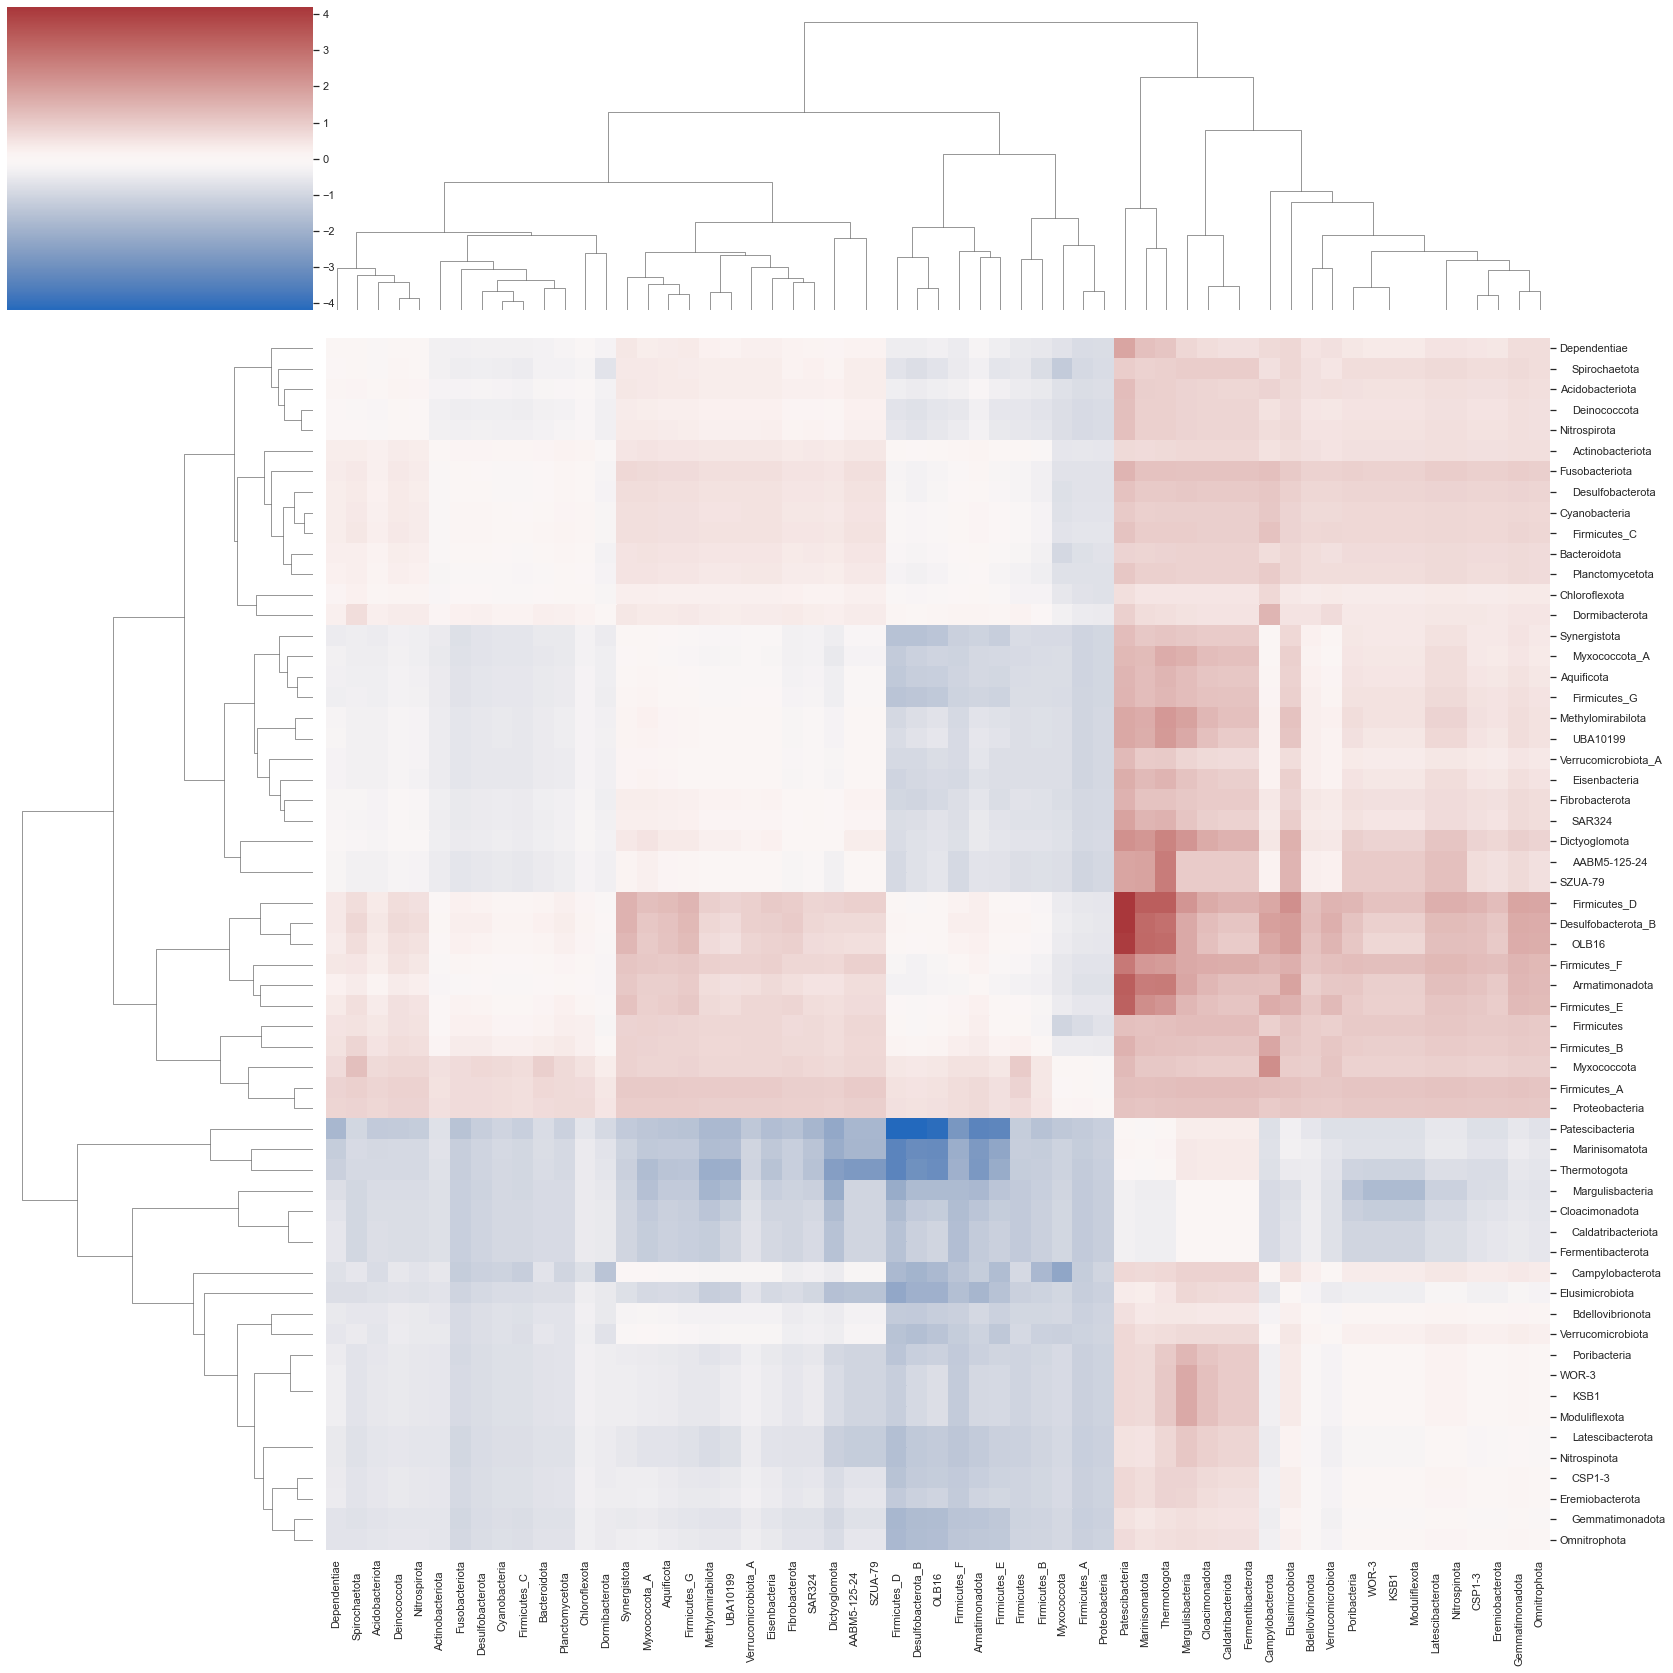

In [162]:
#fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))

# vlag is also a good color_palette
# coolwarm is also a good color_palette
# sns.heatmap(cohend,  cmap=sns.color_palette("vlag", as_cmap=True), ax=ax, xticklabels=1, yticklabels=1)
sns.set_theme(color_codes=True)
ax = sns.clustermap(
    cohenclean, 
    cmap=sns.color_palette("vlag", as_cmap=True),
    figsize=(23.4, 23.4),
)

"""
# get the tick labels and change some parameters about them.
xticks_loc = ax.get_xticklabels()
lx = ax.set_xticklabels(xticks_loc, fontsize=10)
# use this to hide every other tick
#[x.set_visible(False) for x in lx[::2]]

yticks_loc = ax.get_yticklabels()
ly = ax.set_yticklabels(yticks_loc, fontsize=10)
# use this to hide every other tick
#[y.set_visible(False) for y in ly[1::2]]


# add a slight offset for every other x tick label
for alab in lx[1::4]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))

# add a slight offset for every other y tick label
for alab in ly[2::4]:
    x, y = alab.get_position()
    alab.set_position((x-0.01, y))


"""

# plt.setp(ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=45)

lx = ax.ax_heatmap.xaxis.get_majorticklabels()
for alab in lx[1::2]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))

ly = ax.ax_heatmap.yaxis.get_majorticklabels()
for alab in ly[1::2]:
    x, y = alab.get_position()
    alab.set_position((x+0.01, y))
    

plt.tight_layout()
fig.savefig('images/cohen_clustmap.svg')